# Data Collection, Data Visualization, Data Exploration and Data Processing

<b>Project Title:</b> Spotify Song Popularity Prediction

## Group 4:
- Rahul Nenavath
- Krithika Annaswamy Kannan

### Import Necessary Libraries:

In [ ]:
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from collections import namedtuple
from scipy.stats import pearsonr, spearmanr, shapiro, probplot
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


warnings.filterwarnings('ignore')

### Loading data:

The dataset is uploaded in the personal public S3 Bucket for easy of access. In the following code cells the dataset zip is downloaded from the S3 bucket, unzipped and finally the csv is loaded as a pandas dataframe.

In [ ]:
!wget 'https://rahul-public-datasets.s3.ap-south-1.amazonaws.com/song-prediction-data.zip'

--2024-04-04 00:04:11--  https://rahul-public-datasets.s3.ap-south-1.amazonaws.com/song-prediction-data.zip
Resolving rahul-public-datasets.s3.ap-south-1.amazonaws.com (rahul-public-datasets.s3.ap-south-1.amazonaws.com)... 52.219.156.42, 16.12.40.74, 52.219.62.123, ...
Connecting to rahul-public-datasets.s3.ap-south-1.amazonaws.com (rahul-public-datasets.s3.ap-south-1.amazonaws.com)|52.219.156.42|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1216068 (1.2M) [application/zip]
Saving to: ‘song-prediction-data.zip’

song-prediction-dat 100%[===================>]   1.16M   891KB/s    in 1.3s    

2024-04-04 00:04:13 (891 KB/s) - ‘song-prediction-data.zip’ saved [1216068/1216068]



In [ ]:
!unzip '/content/song-prediction-data.zip' -d '/content'

Archive:  /content/song-prediction-data.zip
  inflating: /content/song_data.csv  
  inflating: /content/__MACOSX/._song_data.csv  
  inflating: /content/song_info.csv  
  inflating: /content/__MACOSX/._song_info.csv  


In [ ]:
data = pd.read_csv('/content/song_data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18835 entries, 0 to 18834
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   song_name         18835 non-null  object 
 1   song_popularity   18835 non-null  int64  
 2   song_duration_ms  18835 non-null  int64  
 3   acousticness      18835 non-null  float64
 4   danceability      18835 non-null  float64
 5   energy            18835 non-null  float64
 6   instrumentalness  18835 non-null  float64
 7   key               18835 non-null  int64  
 8   liveness          18835 non-null  float64
 9   loudness          18835 non-null  float64
 10  audio_mode        18835 non-null  int64  
 11  speechiness       18835 non-null  float64
 12  tempo             18835 non-null  float64
 13  time_signature    18835 non-null  int64  
 14  audio_valence     18835 non-null  float64
dtypes: float64(9), int64(5), object(1)
memory usage: 2.2+ MB


In this problem, we will be making use of various attributes of songs on Spotify platform and estimating a given song's popularity. Hence the response variable will be `song_popularity` and rest of the attributes will be input variables.

### Data Type Investigation:

The above `info` method suggests provides us the information on all the datatypes. Apart from `song_name` everything else is Numerical attribute.

### Data Range Validation:
This is an important step because we want to verify whether our numerical attributes are in the expected ranges of each attribute. This step ensures the sample data we pass to the modelling stage represents real-world population data. Data could be corrupted due to data entry issues or error in sensors/data collection apis. We make use of the [Spotify Song API documentation](https://developer.spotify.com/documentation/web-api/reference/get-track) to verify each of these attribute ranges.

In [ ]:
def expected_range(data: pd.DataFrame) -> dict:

  # Check whether a record is inbetween expected bounds
  range_check = lambda x, start, end: True if start <= x <= end else False

  # Named Tuple structure for better readablility and code management
  ValidationInfo = namedtuple('ValidationInfo',
   ['has_valid_records', 'invalid_entries', 'range_tuple']
                              )
  # Attribute Validation Dictionary. This will be updated after checking each atribute.
  # The expected bounds are setup from the Spotify API
  validation_status = {
      'song_popularity': ValidationInfo(False, [], (0, 100)),
      'song_duration_ms': ValidationInfo(False, [], (60000, 600000)), # 1 min - 10 min
      'acousticness': ValidationInfo(False, [], (0, 1)),
      'danceability': ValidationInfo(False, [], (0, 1)),
      'energy': ValidationInfo(False, [], (0, 1)),
      'instrumentalness': ValidationInfo(False, [], (0, 1)),
      'key': ValidationInfo(False, [], (0, 11)),
      'liveness': ValidationInfo(False, [], (0, 1)),
      'loudness': ValidationInfo(False, [], (-40, 2)),
      'audio_mode': ValidationInfo(False, [], (0, 1)),
      'speechiness': ValidationInfo(False, [], (0, 1)),
      'tempo': ValidationInfo(False, [], (0, 300)),
      'time_signature': ValidationInfo(False, [], (0, 5)),
      'audio_valence': ValidationInfo(False, [],  (0, 1)),
  }

  # Iterate throught each attribute and check whether each record is present in the expected range

  col_status = []
  for col_name in data.columns:
    if col_name in validation_status:
      col_validation_info = validation_status.get(col_name)
      (uplimit, lowlimit) = col_validation_info.range_tuple

      for record in data[col_name]:
        if range_check(record, uplimit, lowlimit):
          col_status.append(1)
        else:
          col_status.append(0)

      if not all(col_status):
        idx_not_in_range = np.argwhere(np.array(col_status) == 0).reshape(1, -1)[0]
        validation_status[col_name]  = col_validation_info._replace(has_valid_records = True)
        col_validation_info.invalid_entries.append(idx_not_in_range)

    col_status.clear()

  return validation_status

In [ ]:
results = expected_range(data)

In [ ]:
for col_name in results:
  validation_structure = results[col_name]
  if validation_structure.has_valid_records:
    print(f'Column: {col_name}\nInvalid Record Index: {validation_structure.invalid_entries}')

Column: song_duration_ms
Invalid Record Index: [array([  236,   314,   479,   501,  1746,  1755,  3726,  3727,  3733,
        3746,  3787,  4137,  4144,  6040,  7119,  7133,  7378, 10227,
       10706, 11125, 11142, 11165, 11262, 11274, 14790, 15296, 16825,
       17620, 17797, 18001, 18056, 18060, 18070, 18147, 18148, 18485])]


As we can see there are certain `songs` whose duration (in ms) is not in the expected range of a typical song. Let's look at each of it's song duration in minutes to investigate whether are these records are errors or just expected outliers.

In [ ]:
x = data.iloc[results['song_duration_ms'].invalid_entries[0]][['song_name', 'song_popularity', 'song_duration_ms']]
convert_to_s = lambda x: f'{x // 60_000}:{x // 1000}'
x['song_duration_min'] = x['song_duration_ms'].apply(convert_to_s)
x

song_name  song_popularity  \
236                                          El Cantante               58   
314                                 The End - Remastered               49   
479    2112: Overture / The Temples Of Syrinx / Disco...               53   
501                               Do You Feel Like We Do               48   
1746                                     Shakara (Oloje)               22   
1755                                              Zombie               30   
3726                                           Thank You               19   
3727   I Have a Dream - The Complete Speech of Martin...               24   
3733                                          1960 What?               22   
3746                             Shirley Chisholm - 1972               12   
3787                                         El Cantante               58   
4137                                        Here Too Far               62   
4144                                               Twins               61   
6040                           Marquee Moon - Remastered               43   
7119             Gina Rodriguez - Latinos Trending Intro                0   
7133                             Parents' Divorce - Live               13   
7378                                           Last Call               50   
10227                              From Moment To Moment               39   
10706                                  Tykky Interludium               58   
11125                                      Just Dripping               52   
11142                                               blxt               51   
11165                                         night time               50   
11262                                          Mambo Inn                0   
11274                                       Babarabatiri                0   
14790                                            Go Bang               35   
15296                                        El Cantante               58   
16825                                     Autobahn - 3-D               33   
17620                                               9.13               26   
17797                                               Play               59   
18001                                            Go Bang               35   
18056                             Where Hope Finds Glory               34   
18060                                       The Avengers               37   
18070                                     Taiko Drumming               40   
18147                                   Army Arrangement               23   
18148                             Sorrow Tears and Blood               18   
18485                                            Go Bang               35   

       song_duration_ms song_duration_min  
236              622520            10:622  
314              710826            11:710  
479             1233666           20:1233  
501              836666            13:836  
1746             805746            13:805  
1755             745653            12:745  
3726              31373              0:31  
3727            1047933           17:1047  
3733             747222            12:747  
3746              35920              0:35  
3787             622520            10:622  
4137              55213              0:55  
4144              50014              0:50  
6040             645000            10:645  
7119              12000              0:12  
7133              53066              0:53  
7378             760973            12:760  
10227            736160            12:736  
10706             50508              0:50  
11125             54539              0:54  
11142             56041              0:56  
11165             59600              0:59  
11262            829586            13:829  
11274            833493            13:833  
14790            664573            11:664  
15296            622520            10:622  
16825    

On personally examining these song titles on Spotify, we found these `songs` that are out of the expected typical song duration range are either long speeches, podcasts, or melodies/instrumentals. These are not exactly songs but definitely considered under Spotify's umbrella of music offerings. Hence we shall consider these as valid records moving forward and not drop them.

### Data Cleaning:

Are there any Missing values present:

In [ ]:
num_df= data.isna().sum()

There are no missing values present in the dataset

In [ ]:
print(f'Number of Duplicate rows: {num_df.duplicated().sum()}')

Number of Duplicate rows: 14


Dropping Duplicates

In [ ]:
num_df.drop_duplicates(inplace=True)

### Exploratory Analysis:

We like to investigate each attribute to understand all the values they typically take and whether they help us in estimating the response variable

#### Summary Statistics

In [ ]:
num_df = data.select_dtypes(include=['number'])

Numeric Data Summary Statisics

In [ ]:
num_df.describe()

song_popularity  song_duration_ms  acousticness  danceability  \
count     18835.000000      1.883500e+04  18835.000000  18835.000000   
mean         52.991877      2.182116e+05      0.258539      0.633348   
std          21.905654      5.988754e+04      0.288719      0.156723   
min           0.000000      1.200000e+04      0.000001      0.000000   
25%          40.000000      1.843395e+05      0.024100      0.533000   
50%          56.000000      2.113060e+05      0.132000      0.645000   
75%          69.000000      2.428440e+05      0.424000      0.748000   
max         100.000000      1.799346e+06      0.996000      0.987000   

             energy  instrumentalness           key      liveness  \
count  18835.000000      18835.000000  18835.000000  18835.000000   
mean       0.644995          0.078008      5.289196      0.179650   
std        0.214101          0.221591      3.614595      0.143984   
min        0.001070          0.000000      0.000000      0.010900   
25%        0.510000          0.000000      2.000000      0.092900   
50%        0.674000          0.000011      5.000000      0.122000   
75%        0.815000          0.002570      8.000000      0.221000   
max        0.999000          0.997000     11.000000      0.986000   

           loudness    audio_mode   speechiness         tempo  time_signature  \
count  18835.000000  18835.000000  18835.000000  18835.000000    18835.000000   
mean      -7.447435      0.628139      0.102099    121.073154        3.959119   
std        3.827831      0.483314      0.104378     28.714456        0.298533   
min      -38.768000      0.000000      0.000000      0.000000        0.000000   
25%       -9.044000      0.000000      0.037800     98.368000        4.000000   
50%       -6.555000      1.000000      0.055500    120.013000        4.000000   
75%       -4.908000      1.000000      0.119000    139.931000        4.000000   
max        1.585000      1.000000      0.941000    242.318000        5.000000   

       audio_valence  
count   18835.000000  
mean        0.527967  
std         0.244632  
min         0.000000  
25%         0.335000  
50%         0.527000  
75%         0.725000  
max         0.984000

**Observations:**
- Attributes like acousticness, danceability, energy, instrumentalness, liveness, audio_mode, speechiness, audio_valence are in the ranges 0 to 1. <br>
- Skewness is present in: song_duration_ms, acousticness, instrumentalness, loudness & speechiness. <br>
- Multiple attributes have very small standard deviation indicating the variance in the attribute is minimum.

#### Univariate & Bivariate Analysis

Understanding the centrality & dispersion of the response variable - `song popularity`

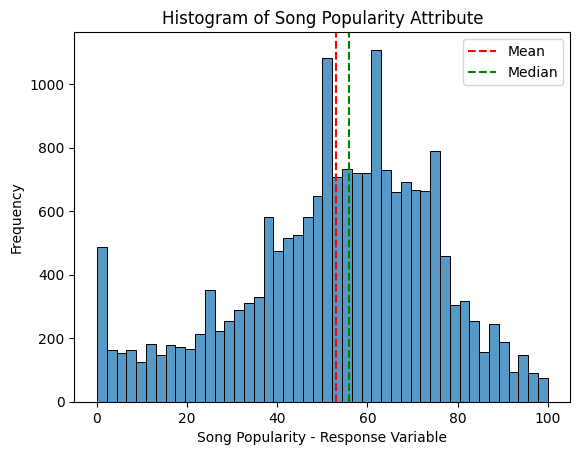

In [ ]:
sns.histplot(x=num_df['song_popularity'])
plt.axvline(x=num_df['song_popularity'].mean(),
            label='Mean', color='red', linestyle='--')
plt.axvline(x=num_df['song_popularity'].median(),
            label='Median', color='green', linestyle='--')

plt.title('Histogram of Song Popularity Attribute')
plt.xlabel('Song Popularity - Response Variable')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Shapiro Statistic: 0.3957136273384094
Shapiro P-value: 0.0


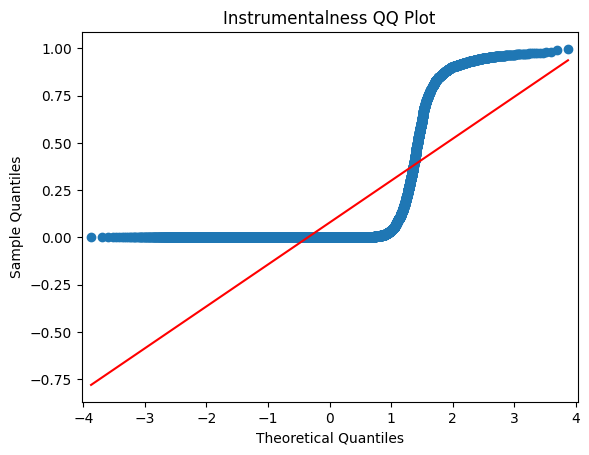

In [ ]:
stat, p = shapiro(num_df['instrumentalness'])
print('Shapiro Statistic:', stat)
print('Shapiro P-value:', p)

sm.qqplot(num_df['instrumentalness'], line='s')
plt.title('Instrumentalness QQ Plot')
plt.show()

**Observation**: Majority of the songs have 40 - 70 score (average score) and rest of the scores are on the extremes. This was expected from a popularity based data.

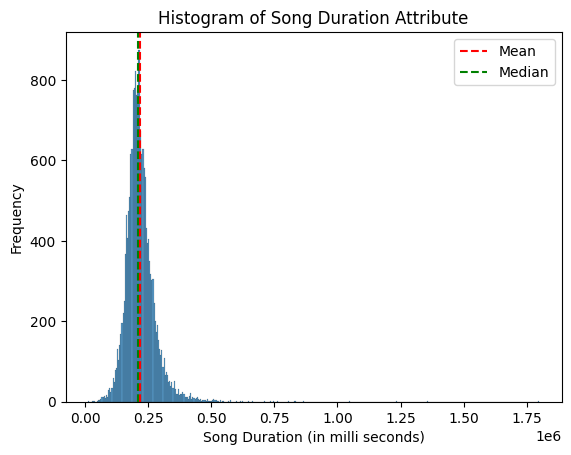

In [ ]:
sns.histplot(x=num_df['song_duration_ms'])
plt.axvline(x=num_df['song_duration_ms'].mean(),
            label='Mean', color='red', linestyle='--')
plt.axvline(x=num_df['song_duration_ms'].median(),
            label='Median', color='green', linestyle='--')

plt.title('Histogram of Song Duration Attribute')
plt.xlabel('Song Duration (in milli seconds)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Majority of the songs are centrally located around 3 min +/- 20 sec. However, due to certain records that are actually podcasts, speeches, melodies (as seen in the above section) the data is heavily right skewed. Applying Log transformation to find clear patterns in the data.

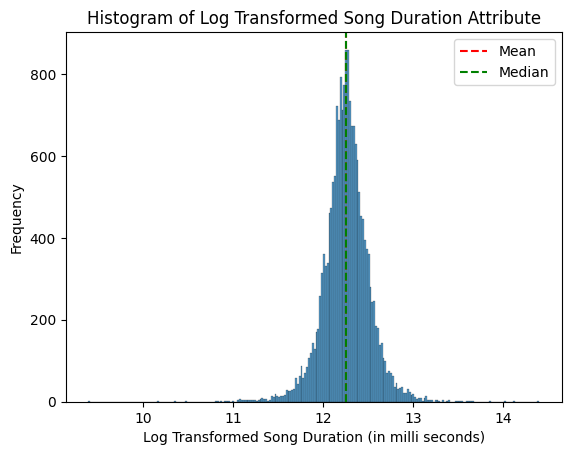

In [ ]:
log_duration = num_df['song_duration_ms'].apply(np.log)
sns.histplot(x=log_duration)
plt.axvline(x=log_duration.mean(),
            label='Mean', color='red', linestyle='--')
plt.axvline(x=log_duration.median(),
            label='Median', color='green', linestyle='--')

plt.title('Histogram of Log Transformed Song Duration Attribute')
plt.xlabel('Log Transformed Song Duration (in milli seconds)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Now the extreme values look to be contained within a certain bound and the data seem to be evenly spread. Let's look at the relationship between log transformed song duration and song popularity.

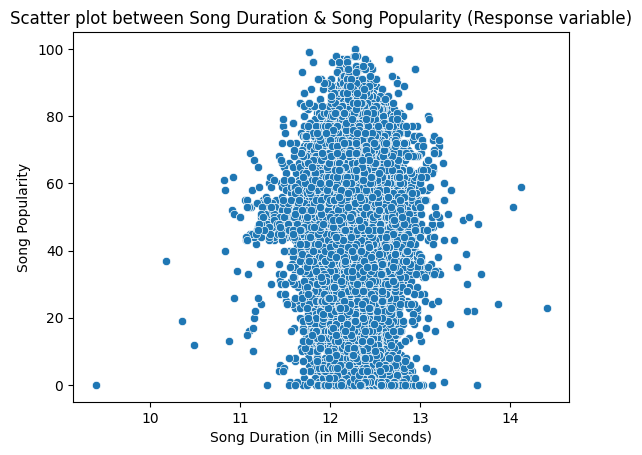

In [ ]:
sns.scatterplot(x=log_duration, y=num_df['song_popularity'])
plt.title('Scatter plot between Song Duration & Song Popularity (Response variable)')
plt.xlabel('Song Duration (in Milli Seconds)')
plt.ylabel('Song Popularity')
plt.show()

The outliers in the song duration not helping us to see the pattern. Let's try to remove the songs that are less than 1 min and more than 8 min, then check the relationship between song duration and song popularity

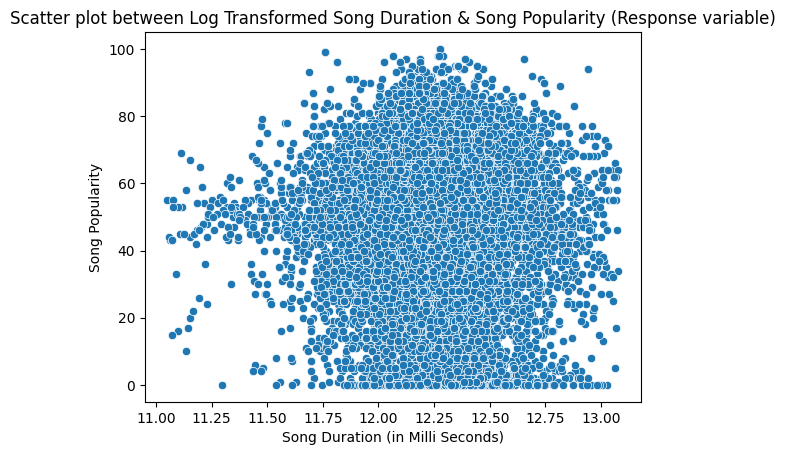

In [ ]:
# Removing the songs with less duration 1 min and more duration than 8 min
x = num_df[(num_df['song_duration_ms'] > 60_000) & (num_df['song_duration_ms'] < 4_80_000)][['song_popularity', 'song_duration_ms']]
x['song_duration_ms_log'] = x['song_duration_ms'].apply(np.log)

sns.scatterplot(x=x['song_duration_ms_log'], y=x['song_popularity'])
plt.title('Scatter plot between Log Transformed Song Duration & Song Popularity (Response variable)')
plt.xlabel('Song Duration (in Milli Seconds)')
plt.ylabel('Song Popularity')
plt.show()

**Observation:** Above plot makes it clear that there is no linear relationship between song duration & song popularity. There might be a non-linear relationship but that needs to be investigated further.

Now let's plot most of the attributes between 0 & 1 and check their distributions

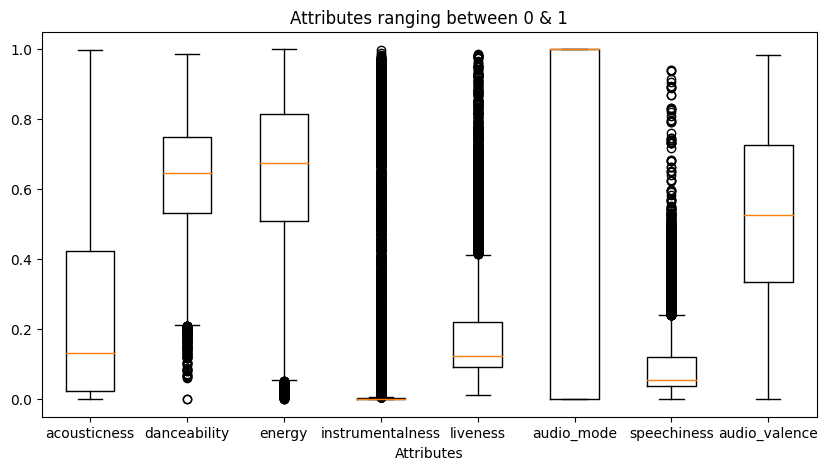

In [ ]:
att_data = {
    'acousticness': num_df['acousticness'],
    'danceability': num_df['danceability'],
    'energy': num_df['energy'],
    'instrumentalness': num_df['instrumentalness'],
    'liveness': num_df['liveness'],
    'audio_mode': num_df['audio_mode'],
    'speechiness': num_df['speechiness'],
    'audio_valence': num_df['audio_valence']
}

fig, ax = plt.subplots(figsize=(10, 5))
ax.boxplot(att_data.values())
plt.title(f'Attributes ranging between 0 & 1')
plt.xlabel(f'Attributes')
ax.set_xticklabels(att_data.keys())
plt.show()

**Observations:** Clearly the attributes are heavily skewed. Especially instrumentalness, liveness, and speechiness have lots of outliers. We can further investigate these. <br><br>Now picking each attribute and plotting them to investigate further.

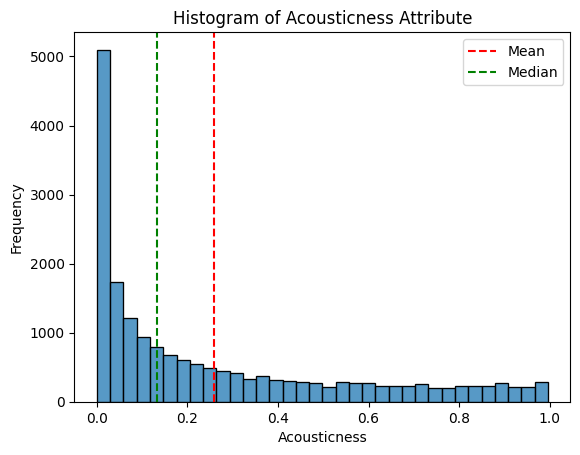

In [ ]:
sns.histplot(x=num_df['acousticness'])
plt.axvline(x=num_df['acousticness'].mean(),
            label='Mean', color='red', linestyle='--')
plt.axvline(x=num_df['acousticness'].median(),
            label='Median', color='green', linestyle='--')

plt.title('Histogram of Acousticness Attribute')
plt.xlabel('Acousticness')
plt.ylabel('Frequency')
plt.legend()
plt.show()

The Acousticness attribute is heavy right skewed. Let's try to apply log transformation and see whether we can interpret this attribute much better.

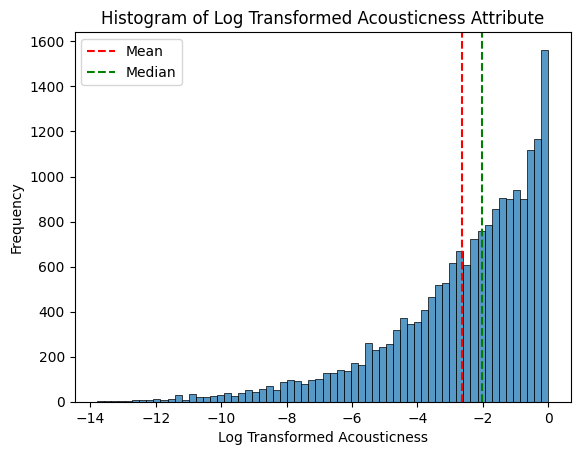

In [ ]:
log_acou = num_df['acousticness'].apply(np.log)
sns.histplot(x=log_acou)
plt.axvline(x=log_acou.mean(),
            label='Mean', color='red', linestyle='--')
plt.axvline(x=log_acou.median(),
            label='Median', color='green', linestyle='--')

plt.title('Histogram of Log Transformed Acousticness Attribute')
plt.xlabel('Log Transformed Acousticness')
plt.ylabel('Frequency')
plt.legend()
plt.show()

**Observation:** The Log Transformed Acousticness attribute seem have a wider spread compared to the data in data form. Even the Standard Deviation of the attribute in the Log Transformation has improved from `0.28` to `2.30`. Looking at the relationship between song popularity & acousticness

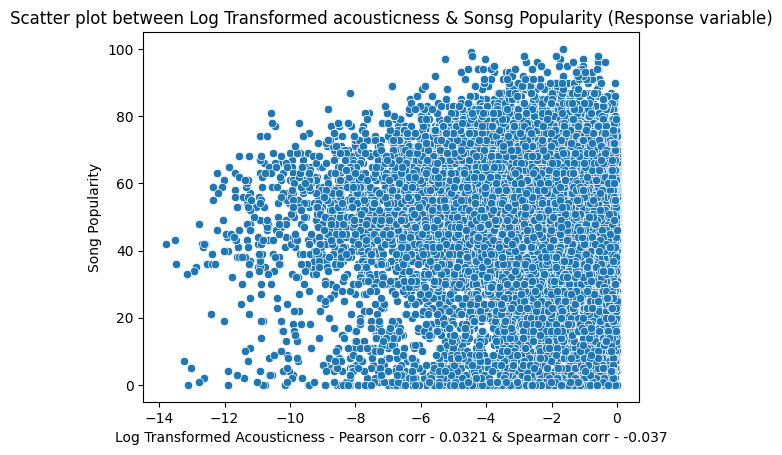

In [ ]:
sns.scatterplot(x=log_acou, y=num_df['song_popularity'])
plt.title('Scatter plot between Log Transformed acousticness & Sonsg Popularity (Response variable)')
pcorr = pearsonr(log_acou, num_df['song_popularity']).statistic
scorr = spearmanr(log_acou, num_df['song_popularity']).statistic
plt.xlabel(f'Log Transformed Acousticness - Pearson corr - {round(pcorr, 4)} & Spearman corr - {round(scorr,4)}')
plt.ylabel('Song Popularity')
plt.show()

**Observation:** No strong correlation between Acousticness & Song Popularity. <br><br> Now looking at Danceability

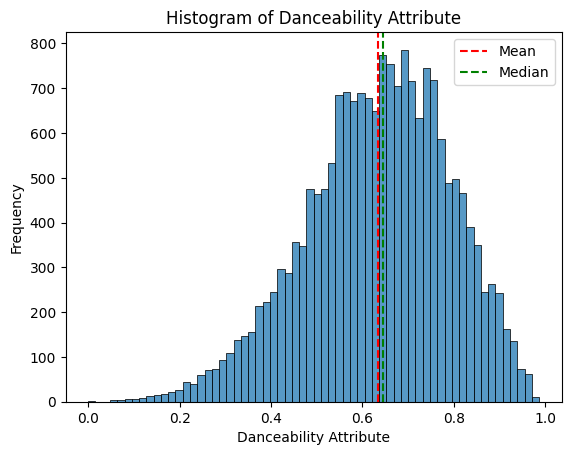

In [ ]:
sns.histplot(x=num_df['danceability'])
plt.axvline(x=num_df['danceability'].mean(),
            label='Mean', color='red', linestyle='--')
plt.axvline(x=num_df['danceability'].median(),
            label='Median', color='green', linestyle='--')

plt.title('Histogram of Danceability Attribute')
plt.xlabel(f'Danceability Attribute')
plt.ylabel('Frequency')
plt.legend()
plt.show()

**Observation:** There is not a big skewness in this attribute. Let's look at how it correlates with response variable

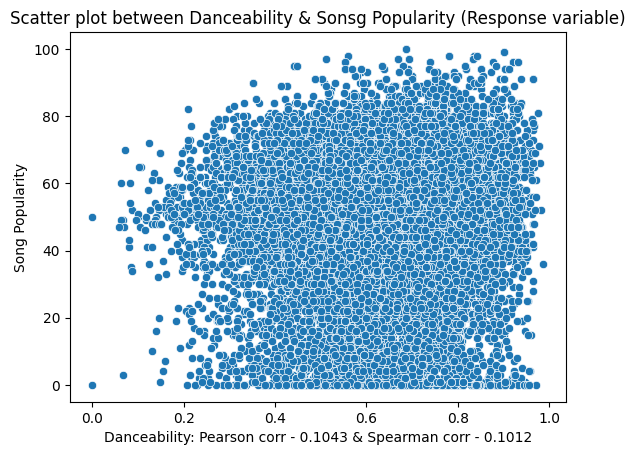

In [ ]:
sns.scatterplot(x=num_df['danceability'], y=num_df['song_popularity'])
plt.title('Scatter plot between Danceability & Sonsg Popularity (Response variable)')
pcorr = pearsonr(num_df['danceability'], num_df['song_popularity']).statistic
scorr = spearmanr(num_df['danceability'], num_df['song_popularity']).statistic
plt.xlabel(f'Danceability: Pearson corr - {round(pcorr, 4)} & Spearman corr - {round(scorr,4)}')
plt.ylabel('Song Popularity')
plt.show()

**Observation:** We don't see a strong correlation between Danceability & Song Popularity! <br><br>Let's look at Energy Attribute now:

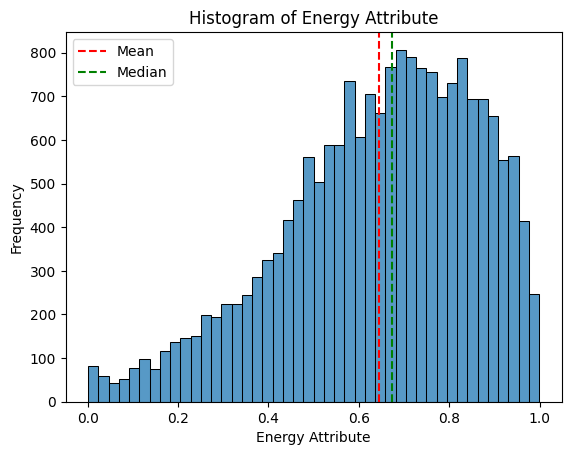

In [ ]:
sns.histplot(x=num_df['energy'])
plt.axvline(x=num_df['energy'].mean(),
            label='Mean', color='red', linestyle='--')
plt.axvline(x=num_df['energy'].median(),
            label='Median', color='green', linestyle='--')

plt.title('Histogram of Energy Attribute')
plt.xlabel(f'Energy Attribute')
plt.ylabel('Frequency')
plt.legend()
plt.show()

**Observation:** We don't see a strong sknewness in the Energy Attribute.

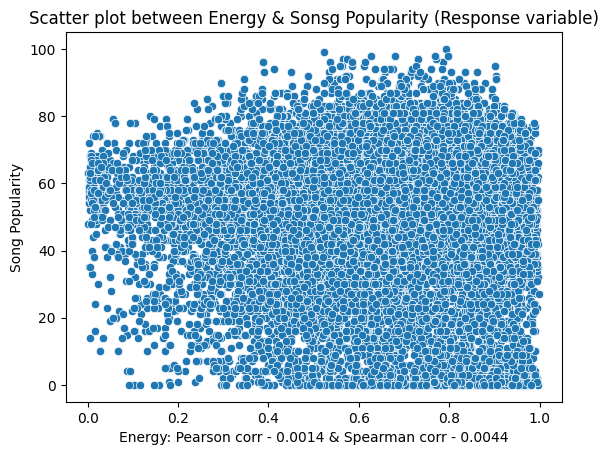

In [ ]:
sns.scatterplot(x=num_df['energy'], y=num_df['song_popularity'])
plt.title('Scatter plot between Energy & Sonsg Popularity (Response variable)')
pcorr = pearsonr(num_df['energy'], num_df['song_popularity']).statistic
scorr = spearmanr(num_df['energy'], num_df['song_popularity']).statistic
plt.xlabel(f'Energy: Pearson corr - {round(pcorr, 4)} & Spearman corr - {round(scorr,4)}')
plt.ylabel('Song Popularity')
plt.show()

**Observation:** We don't see a strong corelation between Energy & Song Popularity. <br><br>Lets look at instrumentalness next

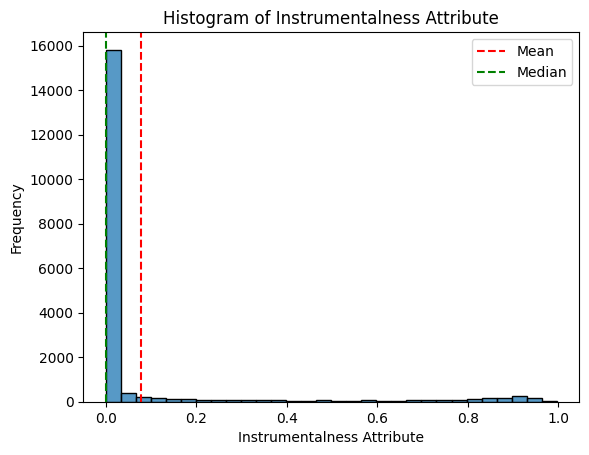

In [ ]:
sns.histplot(x=num_df['instrumentalness'], bins=30)

plt.axvline(x=num_df['instrumentalness'].mean(),
            label='Mean', color='red', linestyle='--')
plt.axvline(x=num_df['instrumentalness'].median(),
            label='Median', color='green', linestyle='--')

plt.title('Histogram of Instrumentalness Attribute')
plt.xlabel(f'Instrumentalness Attribute')
plt.ylabel('Frequency')
plt.legend()
plt.show()

**Observation:** The Intrumentalness Attribute seems to be very skewed. Let's try to apply log and see if it helps.

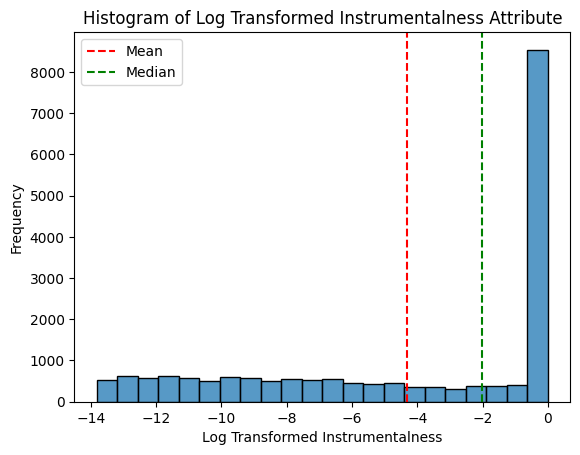

In [ ]:
log_inst = num_df['instrumentalness'].apply(np.log)
log_inst = pd.Series([0 if np.isinf(i) else i for i in log_inst])
sns.histplot(x=log_inst)
plt.axvline(x=log_inst.mean(),
            label='Mean', color='red', linestyle='--')
plt.axvline(x=log_inst.median(),
            label='Median', color='green', linestyle='--')

plt.title('Histogram of Log Transformed Instrumentalness Attribute')
plt.xlabel('Log Transformed Instrumentalness')
plt.ylabel('Frequency')
plt.legend()
plt.show()

**Observation:** Log Transformation clearly helps in spreading the information wider.

In [ ]:
print(f'Sknewness before: {num_df["instrumentalness"].skew()}\nSknewness after: {log_inst.skew()}')

Sknewness before: 2.985176362129132
Sknewness after: -0.5774850926735474


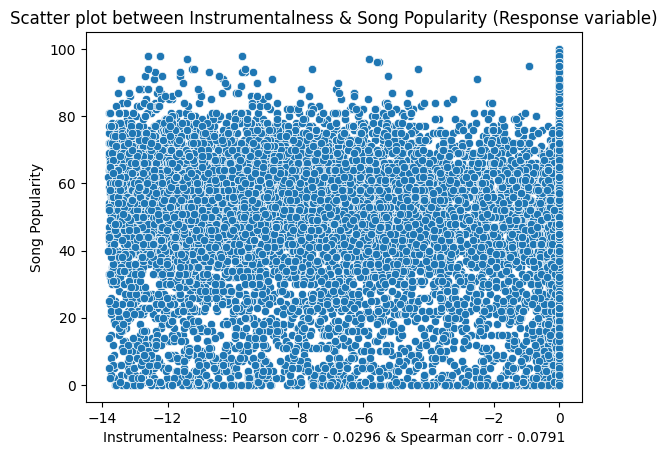

In [ ]:
sns.scatterplot(x=log_inst, y=num_df['song_popularity'])
plt.title('Scatter plot between Instrumentalness & Song Popularity (Response variable)')
pcorr = pearsonr(log_inst, num_df['song_popularity']).statistic
scorr = spearmanr(log_inst, num_df['song_popularity']).statistic
plt.xlabel(f'Instrumentalness: Pearson corr - {round(pcorr, 4)} & Spearman corr - {round(scorr,4)}')
plt.ylabel('Song Popularity')
plt.show()

**Observation:** Again we don't find a strong correlation between Instrumentalness and Song Popularity. <br><br>Looking at key Attribute next

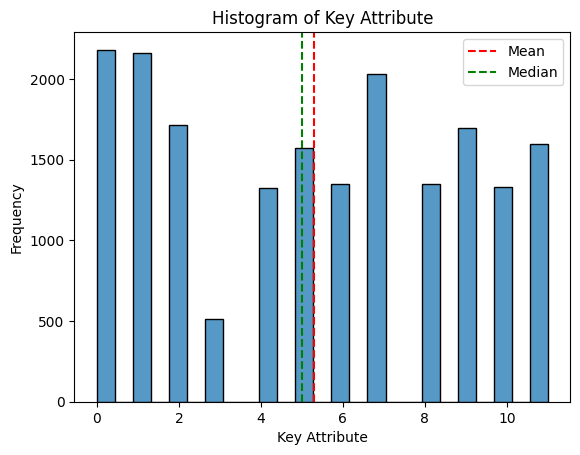

In [ ]:
sns.histplot(x=num_df['key'])

plt.axvline(x=num_df['key'].mean(),
            label='Mean', color='red', linestyle='--')
plt.axvline(x=num_df['key'].median(),
            label='Median', color='green', linestyle='--')

plt.title('Histogram of Key Attribute')
plt.xlabel(f'Key Attribute')
plt.ylabel('Frequency')
plt.legend()
plt.show()

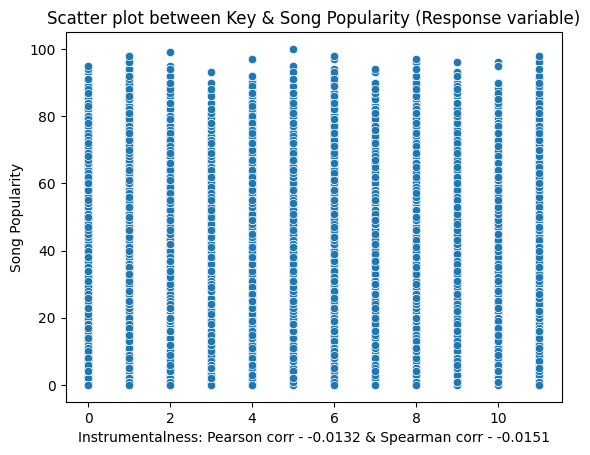

In [ ]:
sns.scatterplot(x=num_df['key'], y=num_df['song_popularity'])
plt.title('Scatter plot between Key & Song Popularity (Response variable)')
pcorr = pearsonr(num_df['key'], num_df['song_popularity']).statistic
scorr = spearmanr(num_df['key'], num_df['song_popularity']).statistic
plt.xlabel(f'Instrumentalness: Pearson corr - {round(pcorr, 4)} & Spearman corr - {round(scorr,4)}')
plt.ylabel('Song Popularity')
plt.show()

**Observations:** The Key and Song Popularity are not correlating. <br><br>Let's look at Liveness next.

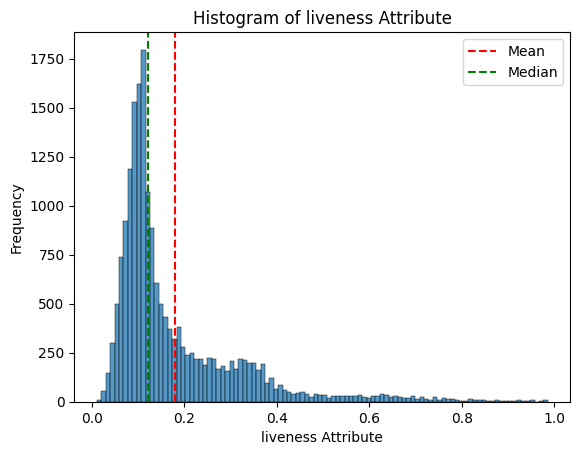

In [ ]:
sns.histplot(x=num_df['liveness'])

plt.axvline(x=num_df['liveness'].mean(),
            label='Mean', color='red', linestyle='--')
plt.axvline(x=num_df['liveness'].median(),
            label='Median', color='green', linestyle='--')

plt.title('Histogram of liveness Attribute')
plt.xlabel(f'liveness Attribute')
plt.ylabel('Frequency')
plt.legend()
plt.show()

**Observations:** This attribute looks very skewed. Let's try to apply log transformation and check the histogram

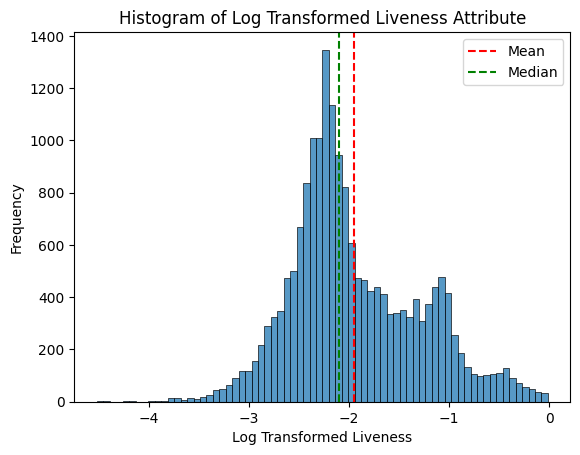

In [ ]:
log_liv = num_df['liveness'].apply(np.log)
sns.histplot(x=log_liv)
plt.axvline(x=log_liv.mean(),
            label='Mean', color='red', linestyle='--')
plt.axvline(x=log_liv.median(),
            label='Median', color='green', linestyle='--')

plt.title('Histogram of Log Transformed Liveness Attribute')
plt.xlabel('Log Transformed Liveness')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [ ]:
print(f'Sknewness before: {num_df["liveness"].skew()}\nSknewness after: {log_liv.skew()}')

Sknewness before: 2.2154226524986247
Sknewness after: 0.5110786708257407


**Observations:** Clearly the log transformation helped in removing the sknewness as sceen from the histogram and the computed score! Now let's see how it correlates with the Song Popularity

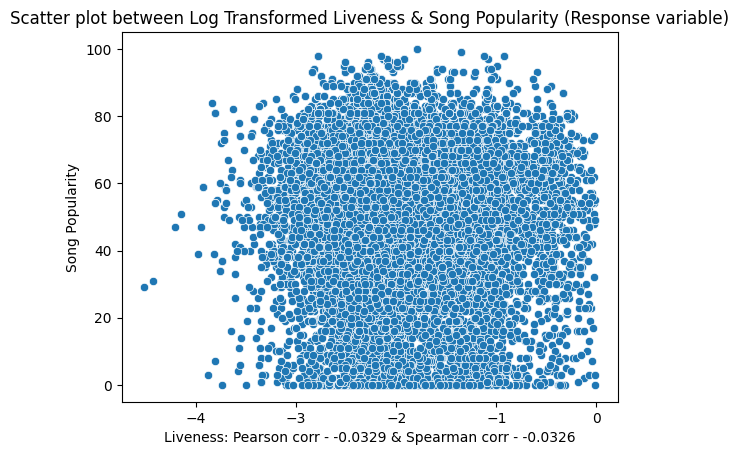

In [ ]:
sns.scatterplot(x=log_liv, y=num_df['song_popularity'])
plt.title('Scatter plot between Log Transformed Liveness & Song Popularity (Response variable)')
pcorr = pearsonr(log_liv, num_df['song_popularity']).statistic
scorr = spearmanr(log_liv, num_df['song_popularity']).statistic
plt.xlabel(f'Liveness: Pearson corr - {round(pcorr, 4)} & Spearman corr - {round(scorr,4)}')
plt.ylabel('Song Popularity')
plt.show()

**Observations:** Not much correlation is observed between log transformed liveness and song popularity. <br><br>Let's look at loudness attribute.

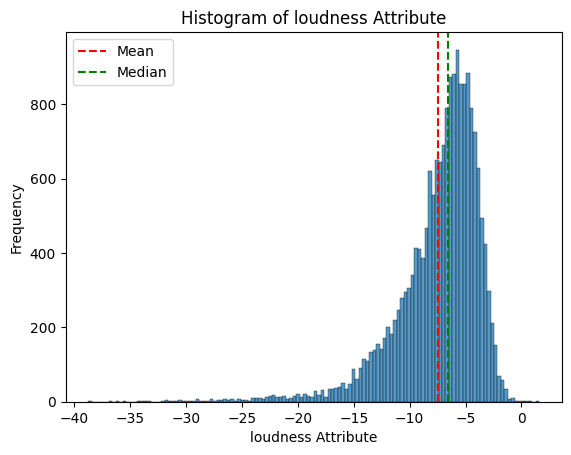

In [ ]:
sns.histplot(x=num_df['loudness'])

plt.axvline(x=num_df['loudness'].mean(),
            label='Mean', color='red', linestyle='--')
plt.axvline(x=num_df['loudness'].median(),
            label='Median', color='green', linestyle='--')

plt.title('Histogram of loudness Attribute')
plt.xlabel(f'loudness Attribute')
plt.ylabel('Frequency')
plt.legend()
plt.show()

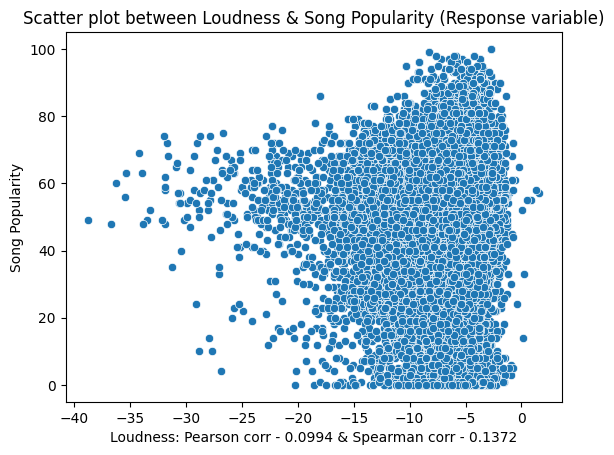

In [ ]:
sns.scatterplot(x=num_df['loudness'], y=num_df['song_popularity'])
plt.title('Scatter plot between Loudness & Song Popularity (Response variable)')
pcorr = pearsonr(num_df['loudness'], num_df['song_popularity']).statistic
scorr = spearmanr(num_df['loudness'], num_df['song_popularity']).statistic
plt.xlabel(f'Loudness: Pearson corr - {round(pcorr, 4)} & Spearman corr - {round(scorr,4)}')
plt.ylabel('Song Popularity')
plt.show()

**Observations:** Again there are no strong correlations between Song popularity and Loudness. <br><br>Let's look at Audio Mode

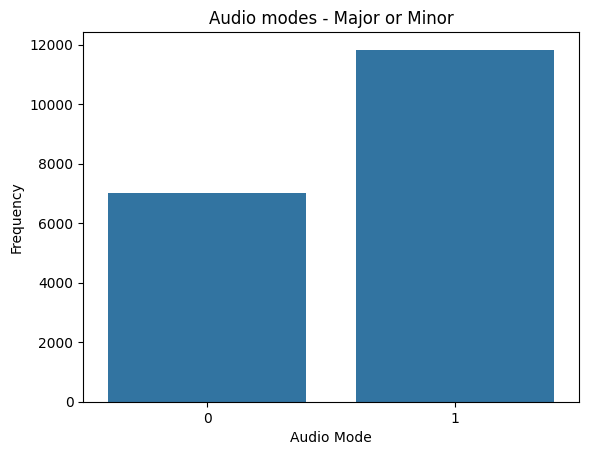

In [ ]:
sns.countplot(x=num_df['audio_mode'])
plt.title(f'Audio modes - Major or Minor')
plt.xlabel('Audio Mode')
plt.ylabel('Frequency')
plt.show()

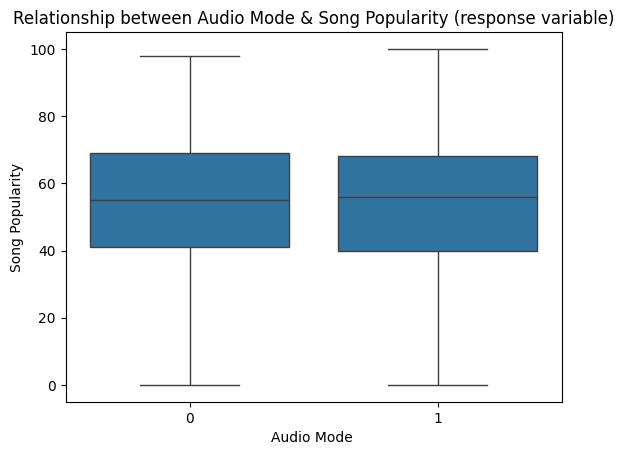

In [ ]:
sns.boxplot(data=num_df, x='audio_mode', y='song_popularity')
plt.title('Relationship between Audio Mode & Song Popularity (response variable)')
plt.xlabel('Audio Mode ')
plt.ylabel('Song Popularity')
plt.show()

**Observation:** There is no strong distinction in Audio mode between Major & Minor w.r.t Song Popularity

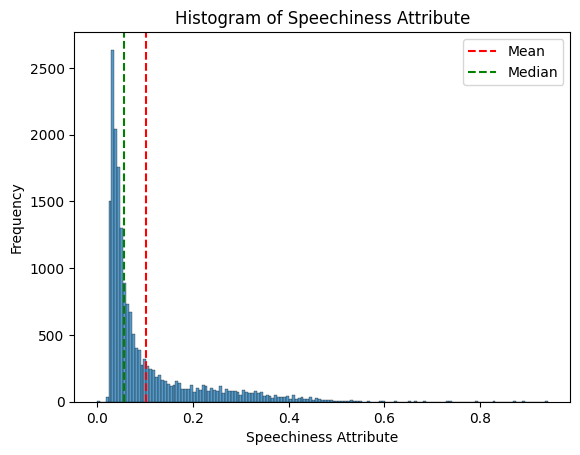

In [ ]:
sns.histplot(x=num_df['speechiness'])

plt.axvline(x=num_df['speechiness'].mean(),
            label='Mean', color='red', linestyle='--')
plt.axvline(x=num_df['speechiness'].median(),
            label='Median', color='green', linestyle='--')

plt.title('Histogram of Speechiness Attribute')
plt.xlabel(f'Speechiness Attribute')
plt.ylabel('Frequency')
plt.legend()
plt.show()

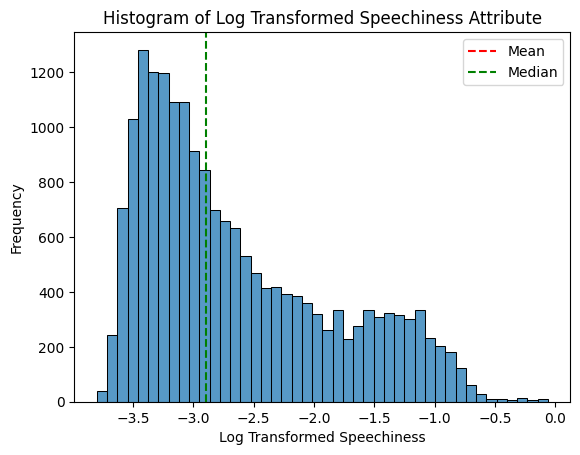

In [ ]:
log_sp = num_df['speechiness'].apply(np.log)
log_sp_imp = pd.Series([0 if np.isinf(i) else i for i in log_sp])

sns.histplot(x=log_sp)
plt.axvline(x=log_sp.mean(),
            label='Mean', color='red', linestyle='--')
plt.axvline(x=log_sp.median(),
            label='Median', color='green', linestyle='--')

plt.title('Histogram of Log Transformed Speechiness Attribute')
plt.xlabel('Log Transformed Speechiness')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [ ]:
print(f'Sknewness before: {num_df["speechiness"].skew()}\nSknewness after: {log_sp_imp.skew()}')

Sknewness before: 2.2710179705790874
Sknewness after: 0.8132396899638383


**Observations:** Clearly log transformation has helped speechiness attribute to show clear patterns in the data

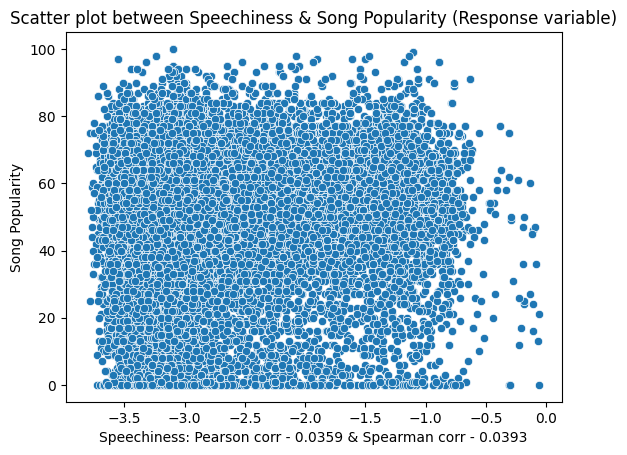

In [ ]:
sns.scatterplot(x=log_sp, y=num_df['song_popularity'])
plt.title('Scatter plot between Speechiness & Song Popularity (Response variable)')
pcorr = pearsonr(log_sp_imp, num_df['song_popularity']).statistic
scorr = spearmanr(log_sp_imp, num_df['song_popularity']).statistic
plt.xlabel(f'Speechiness: Pearson corr - {round(pcorr, 4)} & Spearman corr - {round(scorr,4)}')
plt.ylabel('Song Popularity')
plt.show()

**Observations:** There is no storng correlation between Speechiness & Song Popularity

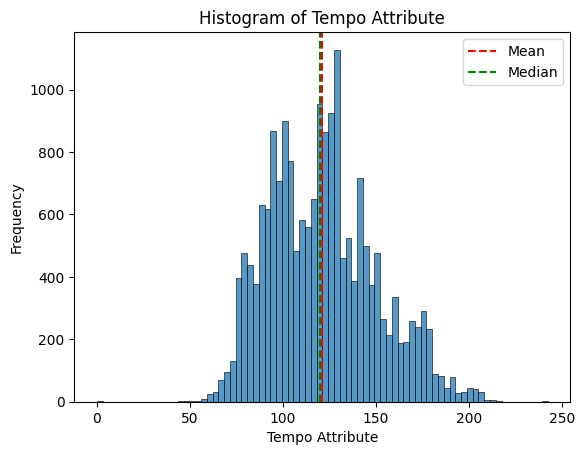

In [ ]:
sns.histplot(x=num_df['tempo'])

plt.axvline(x=num_df['tempo'].mean(),
            label='Mean', color='red', linestyle='--')
plt.axvline(x=num_df['tempo'].median(),
            label='Median', color='green', linestyle='--')

plt.title('Histogram of Tempo Attribute')
plt.xlabel(f'Tempo Attribute')
plt.ylabel('Frequency')
plt.legend()
plt.show()

There is no Sknewness present in the Tempo Attribute.

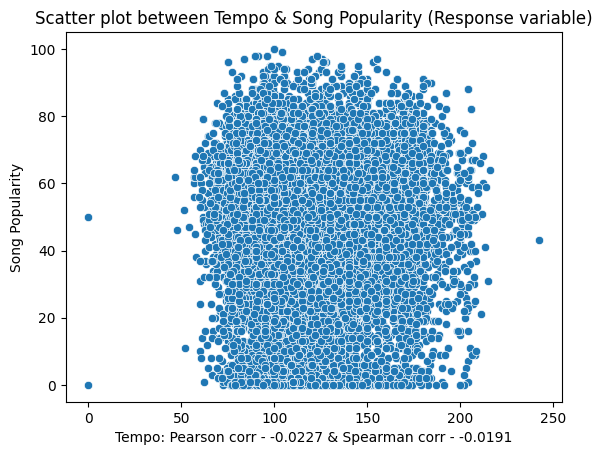

In [ ]:
sns.scatterplot(x=num_df['tempo'], y=num_df['song_popularity'])
plt.title('Scatter plot between Tempo & Song Popularity (Response variable)')
pcorr = pearsonr(num_df['tempo'], num_df['song_popularity']).statistic
scorr = spearmanr(num_df['tempo'], num_df['song_popularity']).statistic
plt.xlabel(f'Tempo: Pearson corr - {round(pcorr, 4)} & Spearman corr - {round(scorr,4)}')
plt.ylabel('Song Popularity')
plt.show()

**Observations:** Again, not correlation is observed between Song Popularity and Tempo. <br><br>Looking at the Time signature Attribute

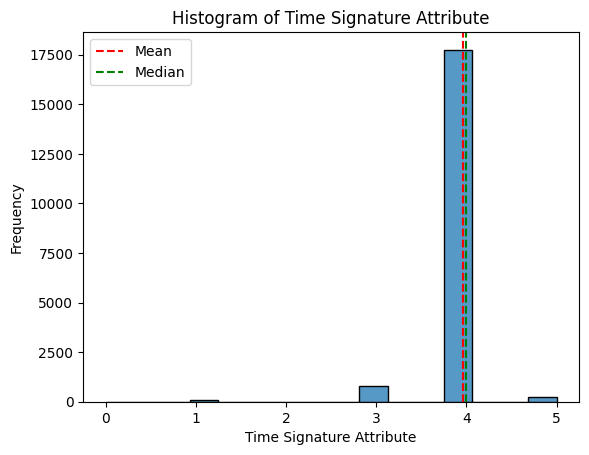

In [ ]:
sns.histplot(x=num_df['time_signature'])

plt.axvline(x=num_df['time_signature'].mean(),
            label='Mean', color='red', linestyle='--')
plt.axvline(x=num_df['time_signature'].median(),
            label='Median', color='green', linestyle='--')

plt.title('Histogram of Time Signature Attribute')
plt.xlabel(f'Time Signature Attribute')
plt.ylabel('Frequency')
plt.legend()
plt.show()

**Observations:** The plot suggests there are majorly 4 beats are in each bar present in the dataset. <br><br>Looking at the Audio Valence Attribute

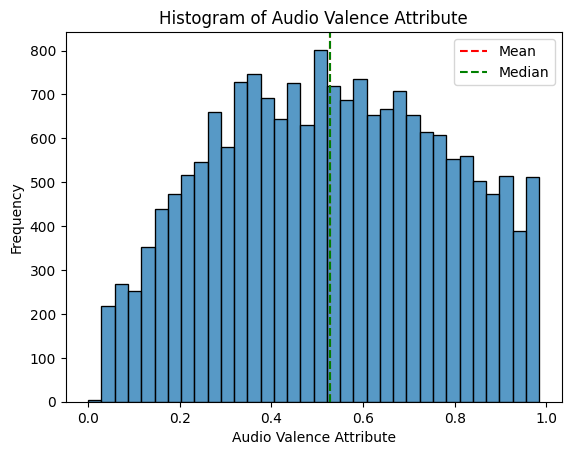

In [ ]:
sns.histplot(x=num_df['audio_valence'])

plt.axvline(x=num_df['audio_valence'].mean(),
            label='Mean', color='red', linestyle='--')
plt.axvline(x=num_df['audio_valence'].median(),
            label='Median', color='green', linestyle='--')

plt.title('Histogram of Audio Valence Attribute')
plt.xlabel(f'Audio Valence Attribute')
plt.ylabel('Frequency')
plt.legend()
plt.show()

**Observations:** Audio valance suggest here there are majoriy of songs with neutral theme as centrality of the data is around 0.4 & 0.6. Interestingly positive theme songs are more in frequency than negative themed songs.

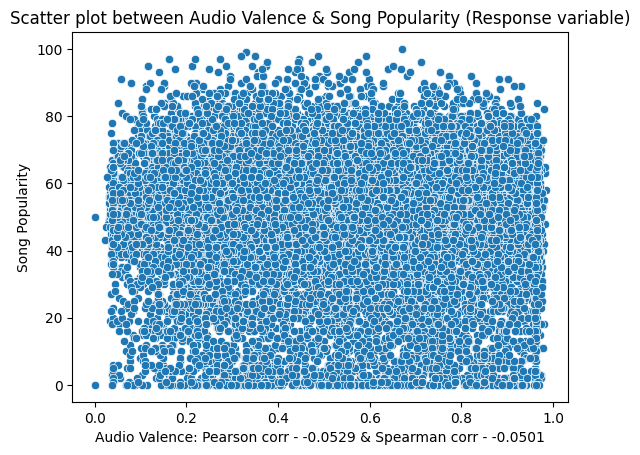

In [ ]:
sns.scatterplot(x=num_df['audio_valence'], y=num_df['song_popularity'])
plt.title('Scatter plot between Audio Valence & Song Popularity (Response variable)')
pcorr = pearsonr(num_df['audio_valence'], num_df['song_popularity']).statistic
scorr = spearmanr(num_df['audio_valence'], num_df['song_popularity']).statistic
plt.xlabel(f'Audio Valence: Pearson corr - {round(pcorr, 4)} & Spearman corr - {round(scorr,4)}')
plt.ylabel('Song Popularity')
plt.show()

**Observations:** Clearly Audio Valance and song popularity don't correlate!

**Inference:** From Univariate Analysis we find the following:
- Input variables are not correlating with reponse variable.
- Variables that require log transformation to reduce skewness:
- -

#### Correlation Analysis
A correlation Heatmap makes it easier to scan the correlations between attributes and understand whether they linearly varying or not. The correlation coefficient, Pearson's correlation coefficient, measures the amount of information being common between two attributes.

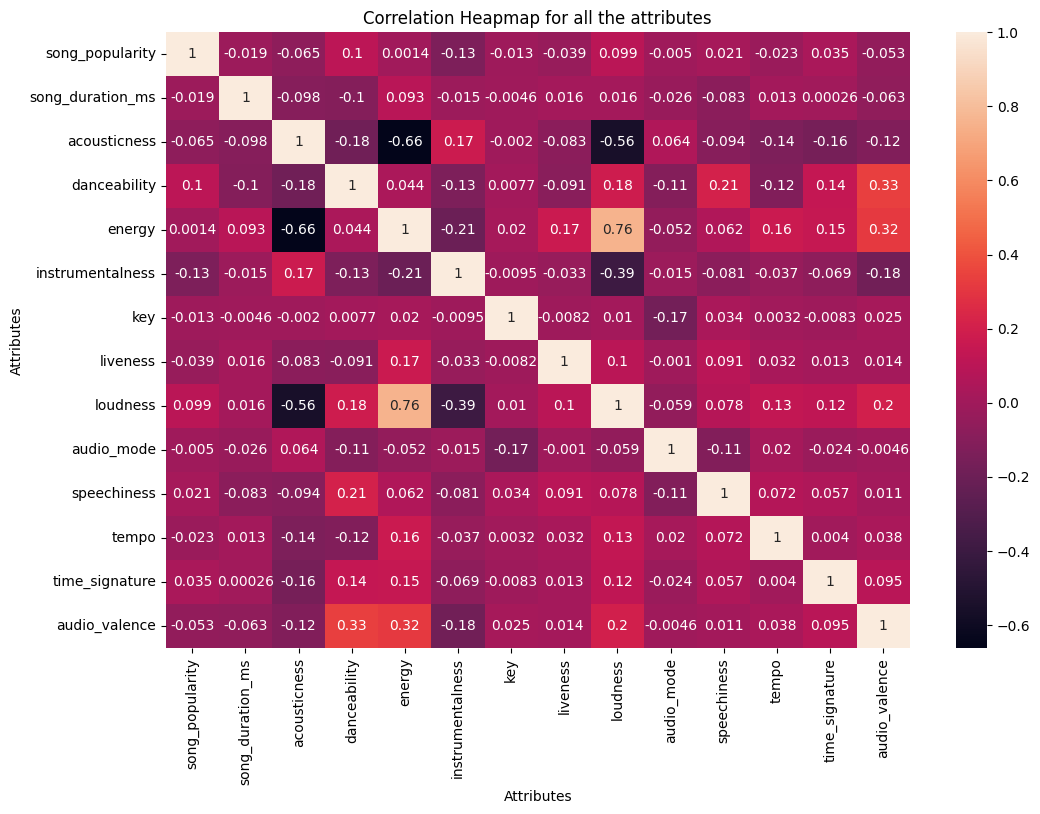

In [ ]:
x = data.drop('song_name', axis=1) # drop the song name as it doesn't give us any information.
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(x.corr(), annot=True, ax=ax)
plt.title(f'Correlation Heapmap for all the attributes')
plt.xlabel('Attributes')
plt.ylabel('Attributes')
plt.show()

**Observations:**
- This Correlation Heatmap summarises the bivariate plots we have seen above between response variable and other input variables. Clearly song_popularity (response variable) is not correlating with other input variables.
- Acousticness is strongly negatively related to energy & loudness - obviously!
- Danceability is weakly positively related to audio valence.
- Energy is strongly positively correlated with Loudness and weakly positively correlated with audio valence - obviously!
- Loudness is weakly negatively correlated with instrumentalness - obviously.


So from the correlation analysis we see infer the following:
- Accouticness, Energy and Loudness share information. Hence we need to drop two of these and keep one.
- We can still keep the weakly correlated attributes.

#### Statisical Tests

We shall perform series of statistical test to understand certain properties about the attributes we have in the dataset.
<br><br>Starting off, Many algorithms require attributes to be normally distributed. We have seen in the univariate analysis that the histogram of majority of numerical attributes resemble guassian curve.

##### Normality Test:
Now lets use `Shapiro-Wilk` test & `QQ-plots` to statisically check the normality of each attribute.

In [ ]:
def check_for_normality(data: pd.DataFrame, attribute_name: str, log_transform: bool) -> None:

  attribute = data[attribute_name]

  if log_transform:
    attribute = attribute.apply(np.log)

  print(f'Shapiro Statistic: {shapiro(attribute.values).statistic} (Closer to 1, the better)\n')
  print(f'Shapiro Pvalue: {shapiro(attribute.values).pvalue} (Closer to 1, the better)\n')
  fix, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

  sns.histplot(x=attribute, ax=ax1)
  res = probplot(attribute, plot=ax2)

  ax1.set_title(f'Histogram of {attribute_name}')
  ax1.set_ylabel(f'Frequency')

  ax2.set_title(f'QQ-plot of {attribute_name}')

  plt.tight_layout()
  plt.show()

Shapiro Statistic: 0.9732723832130432 (Closer to 1, the better)

Shapiro Pvalue: 0.0 (Closer to 1, the better)



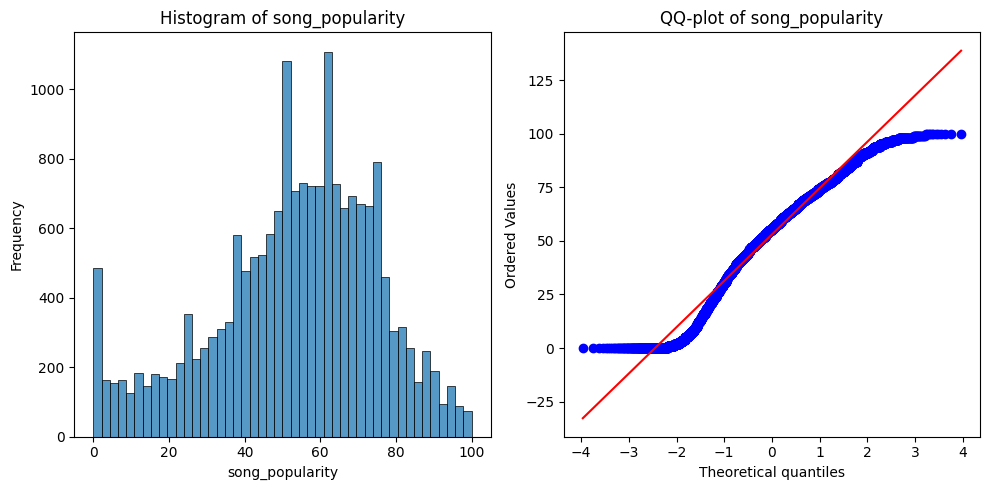

In [ ]:
check_for_normality(data=num_df, attribute_name='song_popularity', log_transform=False)

Shapiro Statistic: 0.9642270803451538 (Closer to 1, the better)

Shapiro Pvalue: 0.0 (Closer to 1, the better)



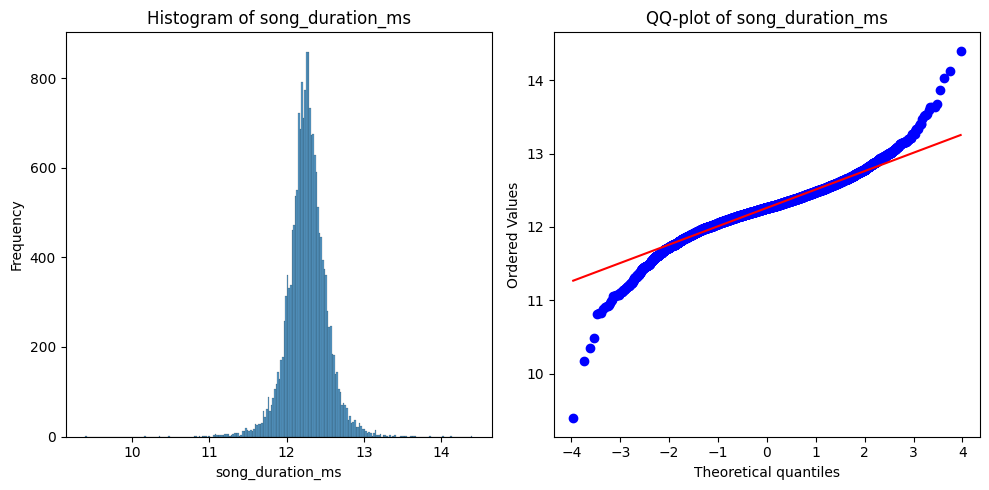

In [ ]:
check_for_normality(data=num_df, attribute_name='song_duration_ms', log_transform=True)

Shapiro Statistic: 0.8815988302230835 (Closer to 1, the better)

Shapiro Pvalue: 0.0 (Closer to 1, the better)



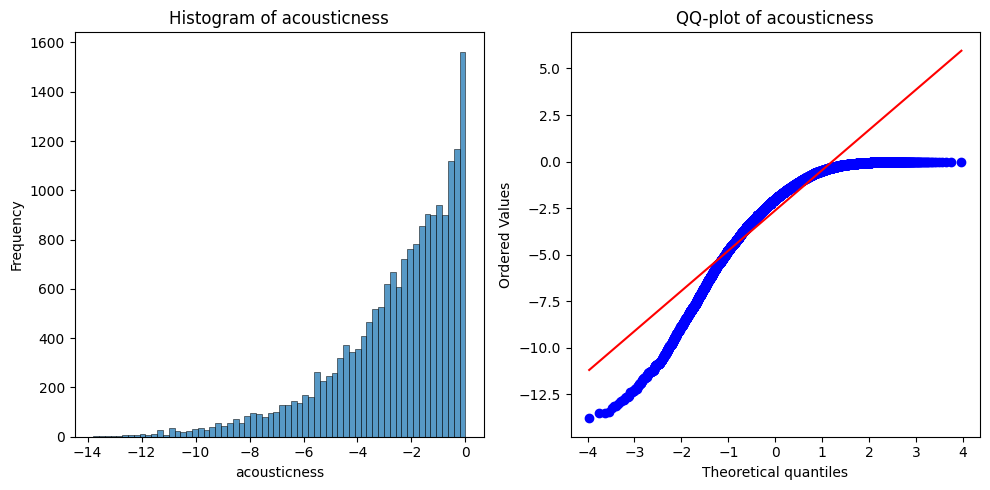

In [ ]:
check_for_normality(data=num_df, attribute_name='acousticness', log_transform=True)

Shapiro Statistic: 0.9886648654937744 (Closer to 1, the better)

Shapiro Pvalue: 9.37163875643808e-36 (Closer to 1, the better)



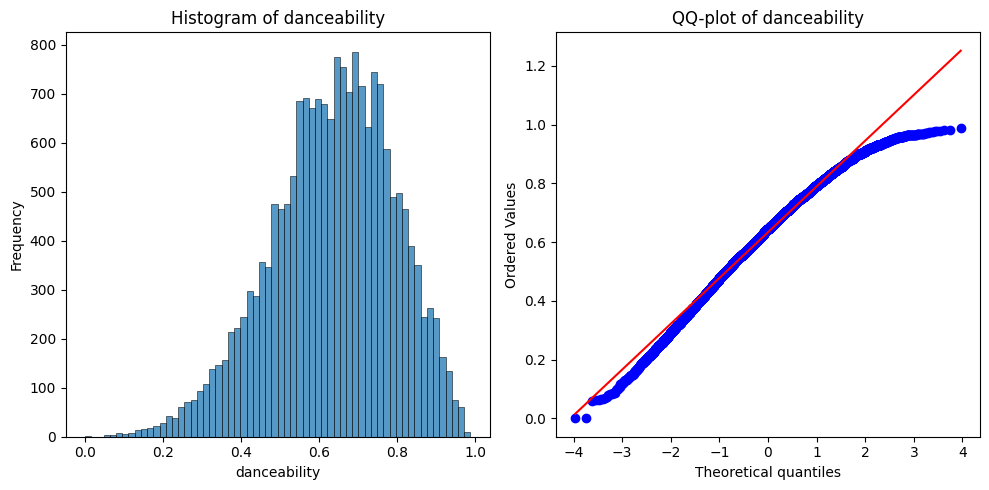

In [ ]:
check_for_normality(data=num_df, attribute_name='danceability', log_transform=False)

Shapiro Statistic: 0.963284969329834 (Closer to 1, the better)

Shapiro Pvalue: 0.0 (Closer to 1, the better)



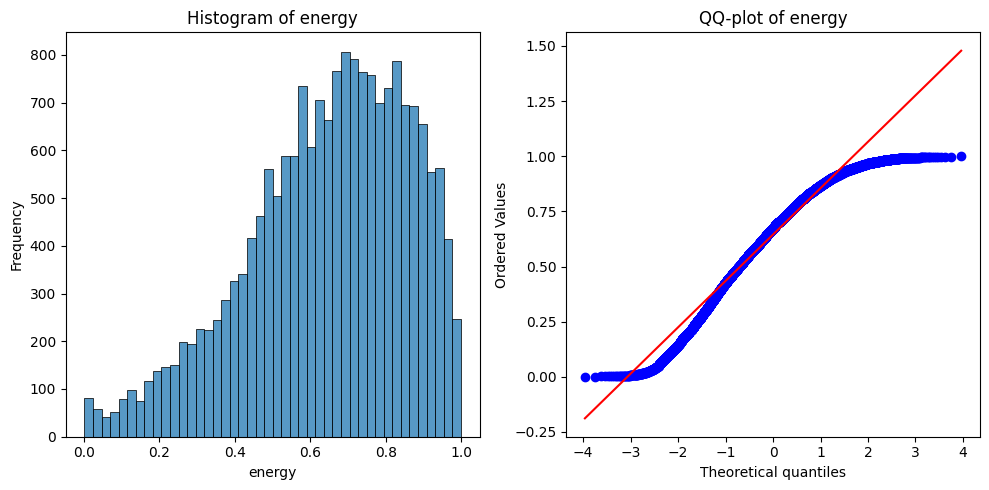

In [ ]:
check_for_normality(data=num_df, attribute_name='energy', log_transform=False)

Shapiro Statistic: nan (Closer to 1, the better)

Shapiro Pvalue: 1.0 (Closer to 1, the better)



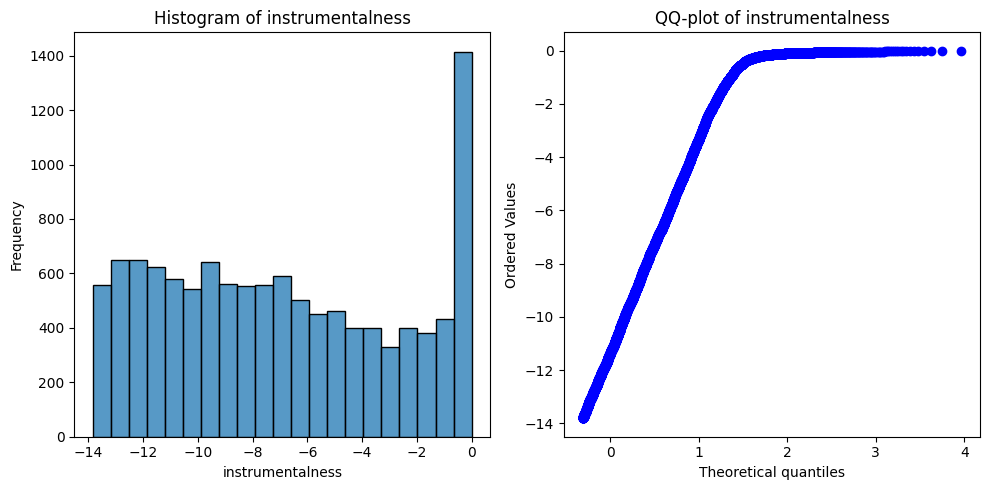

In [ ]:
check_for_normality(data=num_df, attribute_name='instrumentalness', log_transform=True)

Shapiro Statistic: nan (Closer to 1, the better)

Shapiro Pvalue: 1.0 (Closer to 1, the better)



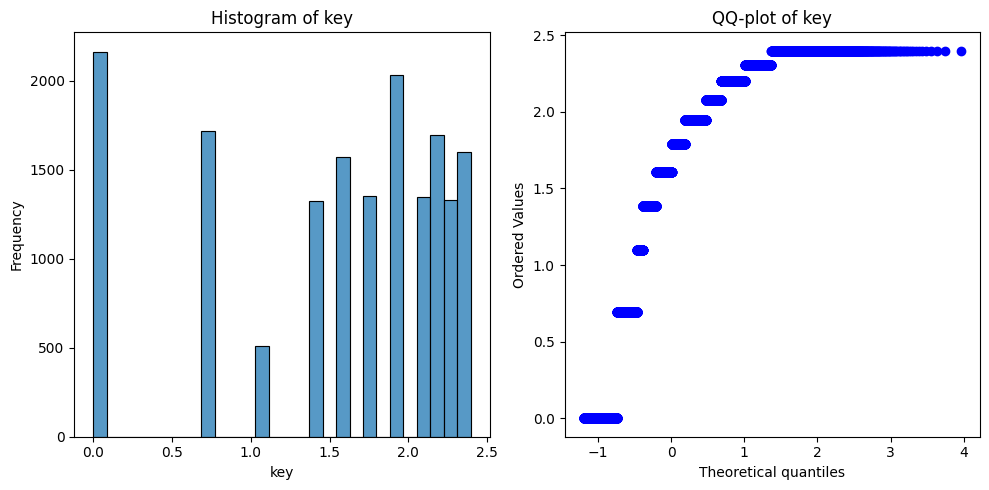

In [ ]:
check_for_normality(data=num_df, attribute_name='key', log_transform=True)

Shapiro Statistic: 0.9694806337356567 (Closer to 1, the better)

Shapiro Pvalue: 0.0 (Closer to 1, the better)



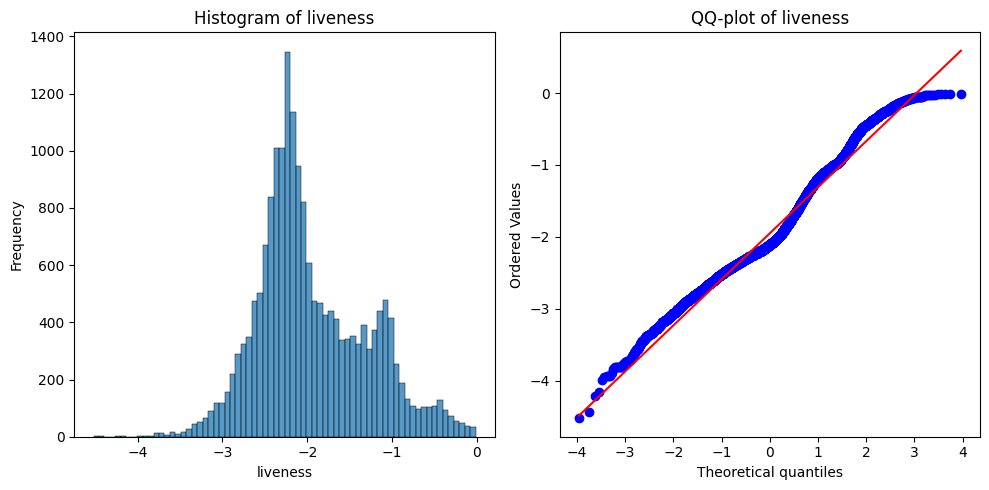

In [ ]:
check_for_normality(data=num_df, attribute_name='liveness', log_transform=True)

Shapiro Statistic: 0.8633536696434021 (Closer to 1, the better)

Shapiro Pvalue: 0.0 (Closer to 1, the better)



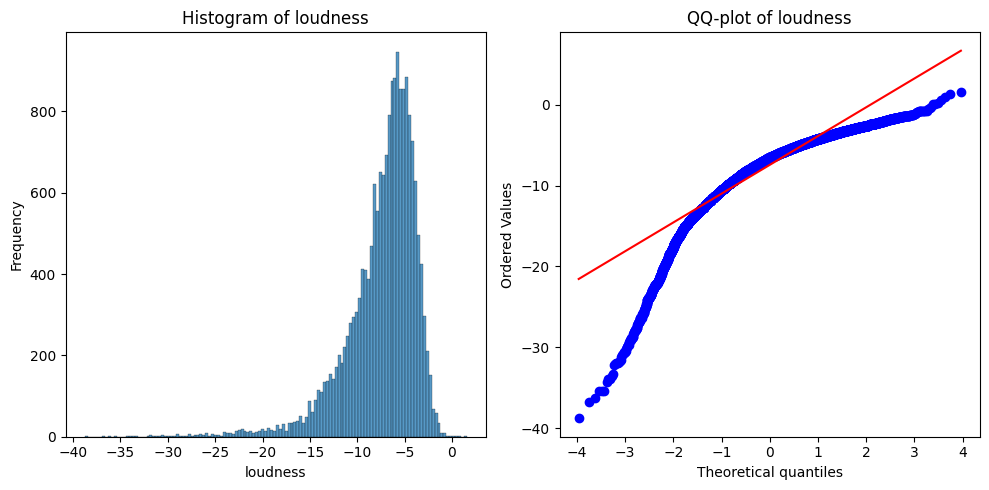

In [ ]:
check_for_normality(data=num_df, attribute_name='loudness', log_transform=False)

Shapiro Statistic: nan (Closer to 1, the better)

Shapiro Pvalue: 1.0 (Closer to 1, the better)



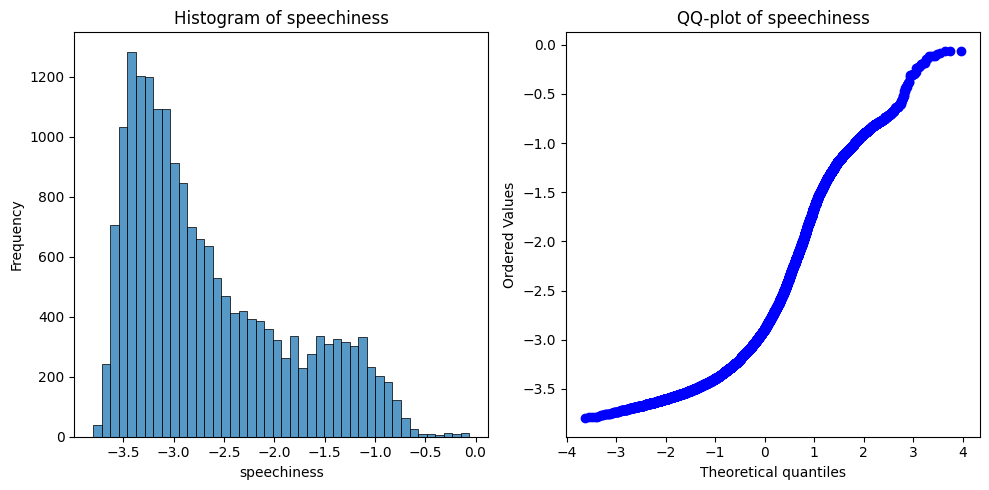

In [ ]:
check_for_normality(data=num_df, attribute_name='speechiness', log_transform=True)

Shapiro Statistic: 0.9806121587753296 (Closer to 1, the better)

Shapiro Pvalue: 3.783505853677006e-44 (Closer to 1, the better)



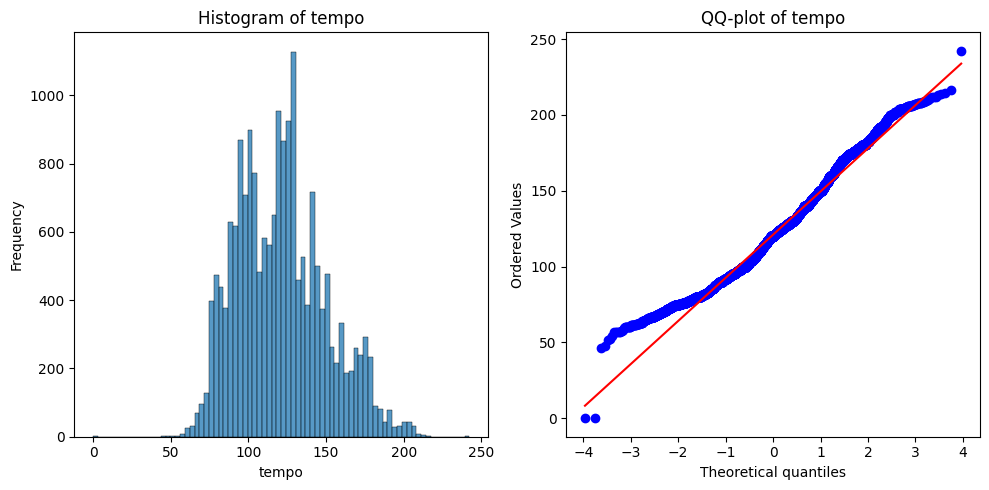

In [ ]:
check_for_normality(data=num_df, attribute_name='tempo', log_transform=False)

Shapiro Statistic: 0.9748213291168213 (Closer to 1, the better)

Shapiro Pvalue: 0.0 (Closer to 1, the better)



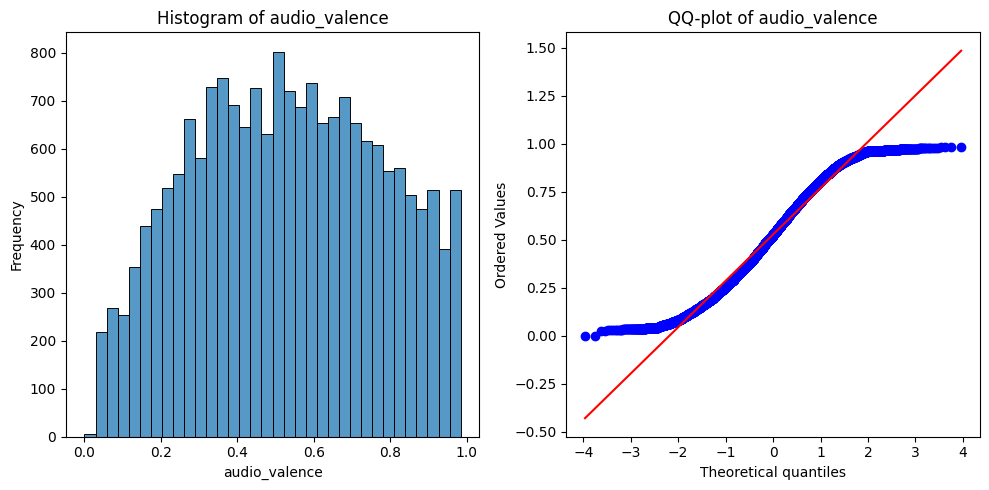

In [ ]:
check_for_normality(data=num_df, attribute_name='audio_valence', log_transform=False)

##### Regression Analysis:
Regression Analysis will help us understanding which attributes are important in estimating song popularity. For this we will be looking at OLS Summary Table as it is a summary from multiple statistical test, namely:
- T-tests between input variables & response variable
- F-tests between intercept-only model and model with all attributes
- Helps in detecting multi-colinearity in the data (we did find it from correlation matrix but we would want to verify it here)

In [ ]:
X = num_df.drop('song_popularity', axis=1).values
y = num_df['song_popularity'].values

In [ ]:
X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     70.09
Date:                Thu, 04 Apr 2024   Prob (F-statistic):          7.07e-182
Time:                        00:05:11   Log-Likelihood:                -84419.
No. Observations:               18835   AIC:                         1.689e+05
Df Residuals:                   18821   BIC:                         1.690e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         62.3520      2.768     22.528      0.0

Do the Data Matrix have Linearly Independent Attributes?

In [ ]:
all(results.eigenvals > True)

True

Yess. All the Attributes are linearly independent as all the eigen values are greater than zero. Let's check whether the input data matrix is Full Rank or not:

In [ ]:
print(f'Is Full Rank: {len(results.eigenvals > True) == min(X.shape)}')

Is Full Rank: True


**Observations:**  Considering a significance level of 0.05 for all statisitcal tests
- P-value of T-tests for attributes: `['song_duration_ms', 'key', 'audio_mode', 'speechiness']` are great than 0.05 - indicating the coefficients of these attributes are not important.
- The condition number is `4,250,000` thereby indicating a strong multicolinearity (ideally less than 1000).
- R-Square & Adjusted R-Square of `0.046` indicates the linear model is not capable to capture the variance in the data. Thereby, indicating the data is not linearly seprable.
- P-value from F-statistic (`7.07e-182 < 0.05`) and P-value from Omni-bus test (`0.000 < 0.05`), indicates the model with all the attributes is much better than the intercept-only model.

In [ ]:
cols_to_drop = [col for col, pval in zip(num_df.columns, results.pvalues) if pval > 0.05]
print(f'Columns with Test pval > 0.05:\n{cols_to_drop}')

Columns with Test pval > 0.05:
['song_duration_ms', 'key', 'audio_mode', 'speechiness']


In [ ]:
X = num_df.drop(cols_to_drop + ['song_popularity'], axis=1)
y = num_df['song_popularity']

In [ ]:
X = sm.add_constant(X)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        song_popularity   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     100.3
Date:                Thu, 04 Apr 2024   Prob (F-statistic):          5.83e-184
Time:                        00:44:37   Log-Likelihood:                -84423.
No. Observations:               18835   AIC:                         1.689e+05
Df Residuals:                   18825   BIC:                         1.689e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               61.3351      2.675  

**Observations:** After removing the attributes that are not important: `['song_duration_ms', 'key', 'audio_mode', 'speechiness']`
- Condition Number is reduced from `4,250,000` to `2280`. Thereby we have controlled the multicollinearity a lot however, we still have multi-collinearity present.
- Most of the attributes have p-value of t-test less than 0.05.

Based on the above results, we are dropping attributes: `['song_duration_ms', 'key', 'audio_mode', 'speechiness']` for further steps.

In [ ]:
num_df.drop(['song_duration_ms', 'key', 'audio_mode', 'speechiness'], axis=1, inplace=True)

Hence, by Regression Analysis we have removed 4 features.

#### Questions:

##### Relationship between song attributes and popularity:

How do attributes like acousticness, danceability, energy, and instrumentalness correlate with song popularity? Are there certain characteristics that tend to make songs more popular?

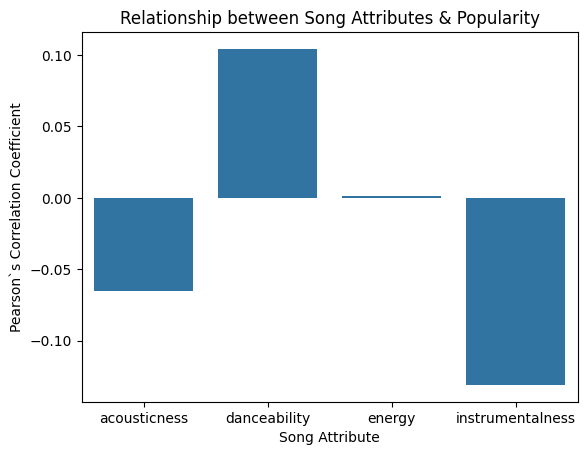

In [ ]:
song_att = ['acousticness', 'danceability', 'energy', 'instrumentalness']
pcoff = data[song_att + ['song_popularity']].corr().loc['song_popularity']
sns.barplot(x=song_att, y=pcoff.drop('song_popularity'))
plt.title(f'Relationship between Song Attributes & Popularity')
plt.xlabel('Song Attribute')
plt.ylabel('Pearson`s Correlation Coefficient')
plt.show()

**Observation:** Clearly no attribute is linearly correlating with song popularity

##### Effect of song duration on song attributes:

Is there a relationship between the duration of a song and its popularity? Do shorter or longer songs tend to be more popular on the platform?

In [ ]:
short_duration = data[data['song_duration_ms'] < 60_000] # < 1 min
long_duration = data[data['song_duration_ms'] > 480000] # > 8 min

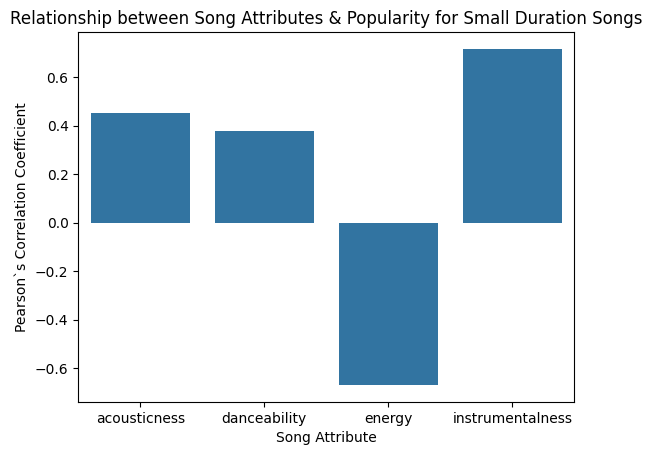

In [ ]:
song_att = ['acousticness', 'danceability', 'energy', 'instrumentalness']
pcoff = short_duration[song_att + ['song_popularity']].corr().loc['song_popularity']
sns.barplot(x=song_att, y=pcoff.drop('song_popularity'))
plt.title(f'Relationship between Song Attributes & Popularity for Small Duration Songs')
plt.xlabel('Song Attribute')
plt.ylabel('Pearson`s Correlation Coefficient')
plt.show()

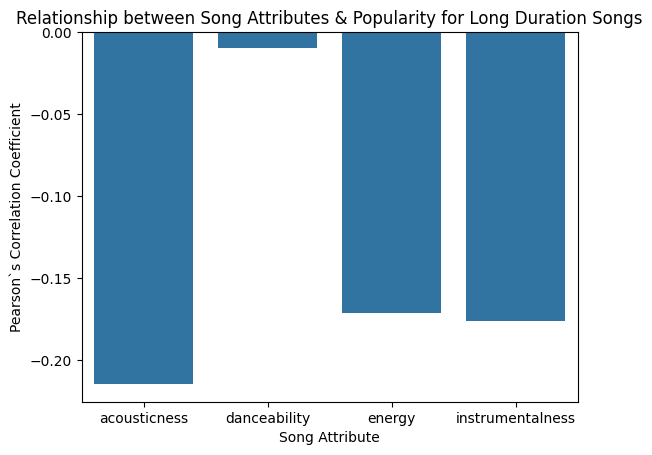

In [ ]:
song_att = ['acousticness', 'danceability', 'energy', 'instrumentalness']
pcoff = long_duration[song_att + ['song_popularity']].corr().loc['song_popularity']
sns.barplot(x=song_att, y=pcoff.drop('song_popularity'))
plt.title(f'Relationship between Song Attributes & Popularity for Long Duration Songs')
plt.xlabel('Song Attribute')
plt.ylabel('Pearson`s Correlation Coefficient')
plt.show()

**Observations:**

##### Analysis of `Key` attribute for different song attributes:

In [ ]:
x = data[song_att + ['key']].groupby('key').mean()

In [ ]:
# Set the width of the bars
barWidth = 0.2

# Set position of bar on X axis
r1 = np.arange(len(x))
r2 = [i + barWidth for i in r1]
r3 = [i + barWidth for i in r2]
r4 = [i + barWidth for i in r3]

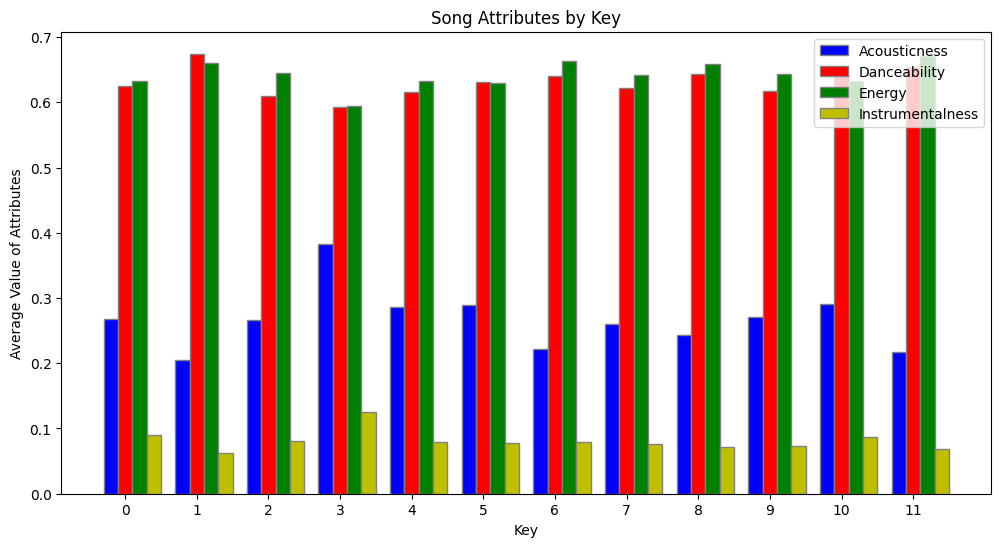

In [ ]:
plt.figure(figsize=(12, 6))
plt.bar(r1, x['acousticness'], color='b', width=barWidth, edgecolor='grey', label='Acousticness')
plt.bar(r2, x['danceability'], color='r', width=barWidth, edgecolor='grey', label='Danceability')
plt.bar(r3, x['energy'], color='g', width=barWidth, edgecolor='grey', label='Energy')
plt.bar(r4, x['instrumentalness'], color='y', width=barWidth, edgecolor='grey', label='Instrumentalness')

plt.xlabel('Keys')
plt.xticks([r + barWidth for r in range(len(x))], x.index)

plt.legend()
plt.title('Song Attributes by Key')
plt.ylabel('Average Value of Attributes')
plt.xlabel('Key')
plt.show()

**Observations:**

##### Impact of song tempo on song attributes:

How does the tempo of a song affect the other song attributes?

In [ ]:
def tempo_clf(t: int):
  if t < 100:
    return 'slow'
  elif t > 150:
    return 'fast'
  else:
    return 'medium'

In [ ]:
x = data[song_att + ['tempo']]
x['tempo_clf'] = x['tempo'].apply(tempo_clf)

In [ ]:
x.drop('tempo', axis=1, inplace=True)
x = x.groupby('tempo_clf').mean()

In [ ]:
# Set the width of the bars
barWidth = 0.2

# Set position of bar on X axis
r1 = np.arange(len(x))
r2 = [i + barWidth for i in r1]
r3 = [i + barWidth for i in r2]
r4 = [i + barWidth for i in r3]

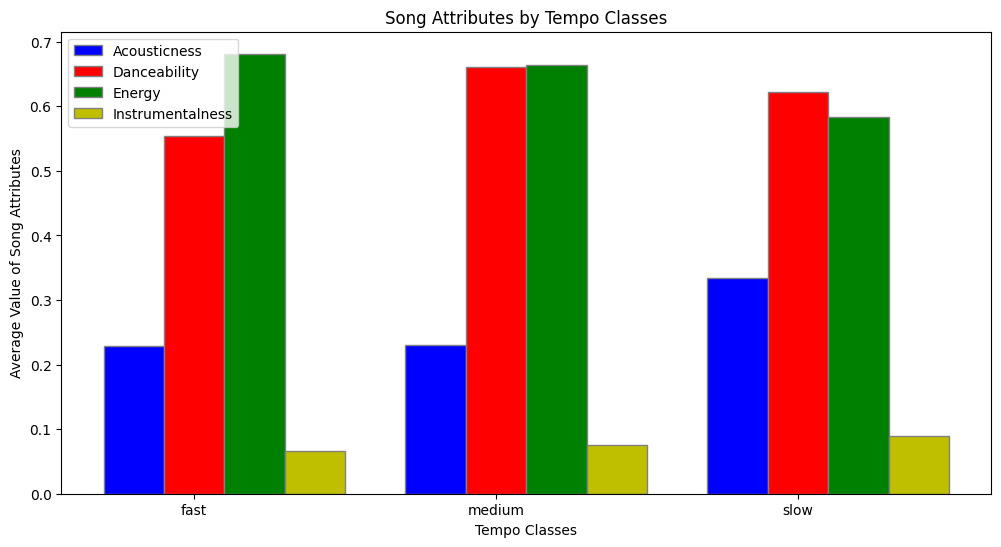

In [ ]:
plt.figure(figsize=(12, 6))
plt.bar(r1, x['acousticness'], color='b', width=barWidth, edgecolor='grey', label='Acousticness')
plt.bar(r2, x['danceability'], color='r', width=barWidth, edgecolor='grey', label='Danceability')
plt.bar(r3, x['energy'], color='g', width=barWidth, edgecolor='grey', label='Energy')
plt.bar(r4, x['instrumentalness'], color='y', width=barWidth, edgecolor='grey', label='Instrumentalness')

plt.xlabel('Tempo classes')
plt.xticks([r + barWidth for r in range(len(x))], x.index)

plt.legend()
plt.title('Song Attributes by Tempo Classes')
plt.ylabel('Average Value of Song Attributes')
plt.xlabel('Tempo Classes')
plt.show()

##### Analysis of audio modes and their effect on song attributes:

Do songs in major or minor keys differ in terms of attributes like energy, valence, or loudness?

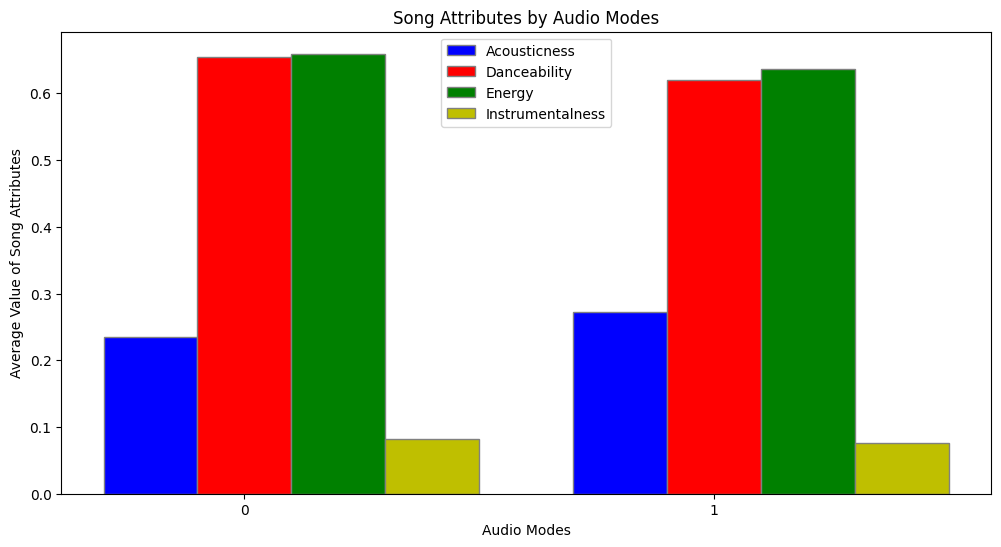

In [ ]:
x = data[song_att + ['audio_mode']]
x_grp = x.groupby(['audio_mode']).mean()

# Set the width of the bars
barWidth = 0.2

# Set position of bar on X axis
r1 = np.arange(len(x_grp))
r2 = [i + barWidth for i in r1]
r3 = [i + barWidth for i in r2]
r4 = [i + barWidth for i in r3]

plt.figure(figsize=(12, 6))
plt.bar(r1, x_grp['acousticness'], color='b', width=barWidth, edgecolor='grey', label='Acousticness')
plt.bar(r2, x_grp['danceability'], color='r', width=barWidth, edgecolor='grey', label='Danceability')
plt.bar(r3, x_grp['energy'], color='g', width=barWidth, edgecolor='grey', label='Energy')
plt.bar(r4, x_grp['instrumentalness'], color='y', width=barWidth, edgecolor='grey', label='Instrumentalness')

plt.xlabel('Audio modes')
plt.xticks([r + barWidth for r in range(len(x_grp))], x_grp.index)

plt.legend()
plt.title('Song Attributes by Audio Modes')
plt.ylabel('Average Value of Song Attributes')
plt.xlabel('Audio Modes')
plt.show()

### Data Split

We will be following a `70, 15, 15` scheme to split the data into Train, Validation, and Test.

In [ ]:
train, test = train_test_split(num_df, test_size=0.15)

In [ ]:
train, validation = train_test_split(train, test_size=0.15)

In [ ]:
print(f'Number of samples in Train: {len(train)}, Validation: {len(validation)}, & Test: {len(test)}')

In [ ]:
Xtrain, ytrain = train.drop('song_popularity', axis=1), train['song_popularity']
Xvalid, yvalid = validation.drop('song_popularity', axis=1), validation['song_popularity']
Xtest, ytest = test.drop('song_popularity', axis=1), test['song_popularity']

### Data Normalization

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
stdscalar = StandardScaler()
stdscalar.fit(Xtrain)
Xtrain_std = stdscalar.transform(Xtrain)
Xvalid_std = stdscalar.transform(Xvalid)
Xtest_std = stdscalar.transform(Xtest)

### Dimensionality Reduction

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA().fit(Xtrain_std)

In [ ]:
Xtrain_comp = pca.transform(Xtrain_std)

In [ ]:
explained_var = pca.explained_variance_ratio_
x_lb = [f'PC-{i+1}' for i in range(len(explained_var))]
plt.bar(x=x_lb, height=explained_var)
plt.title(f'Explained Proportional Variance captured by each component')
plt.xlabel(f'Principle Components')
plt.ylabel(f'Captured Variance')
plt.show()

In [ ]:
explained_var = np.cumsum(pca.explained_variance_ratio_)
x_lb = [f'PC-{i+1}' for i in range(len(explained_var))]
plt.bar(x=x_lb, height=explained_var)
plt.title(f'Cummulative Explained Proportional Variance captured by each component')
plt.xlabel(f'Principle Components')
plt.ylabel(f'Cummulative Captured Variance')
plt.show()

In [ ]:
print(f'Is the Data matrix Full Rank: {np.linalg.matrix_rank(Xtrain_std) == min(Xtrain_std.shape)}')

As we can see, We would need atleast 7 principle compnents (PCs) out of 9 total principle components to caputure more than 90% of variance present in the data. Clearly the PCA is not being effective in capturing the majority variance of the original data in lower dimensions. This is because the attributes in the original data dimension are already orthogonal to each other. This is further verified by finding the rank of the Data Matrix. Our data matrix is having a full rank and thereby the input variables are already orthogonal and hence PCA is not very helpful in reducing the dimensions here. Thereby moving forward we will be using original train, validation and test holdouts.

In [ ]:
print(f'Data Dimensions - Train: {Xtrain.shape, ytrain.shape}, Validation: {Xvalid.shape, yvalid.shape}, Test: {Xtest.shape, ytest.shape}')